# 預測目標: ∆EPS大於零或小於零(增或減)
* 樣本為所有在2010-2017年上市櫃之非金融業公司
* 預測時間點為: 2016-2017年之EPS增減
* X為三表（資產負債表、損益表以及現金流量表）的會計科目，Y為EPS是否增長（0-1變數）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Acc_ML/data" 


Mounted at /content/drive
/content/drive/MyDrive/Acc_ML/data


## 安裝套件

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
import random
import math

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## 資料清洗（Data Cleansing） & 資料前處理（Data Preprocessing）

首先，針對預測變數（Y - 每股盈餘）以及三表中（X - 資產負債表、損益表以及現流表）的資料進行整理，將原始資料整理成模型可以輸入的資料，其中包括：
1. 將資料年份展開 
2. 敘述性統計 
3. 缺失值處理 
4. 資料平減化 
5. 資料合併

### Y - 每股盈餘

In [ ]:
# 匯入資料，並展示資料的前五筆
eps_df = pd.read_excel("./EPS_adjusted.xlsx")
eps_df.head()

,公司,年月,每股盈餘-公司,調整因子,當季底每股盈餘-新報
0,1101 台泥,2017-12-29,2.03,0.809084,2.02
1,1102 亞泥,2017-12-29,1.74,1.000000,1.63
2,1103 嘉泥,2017-12-29,1.39,1.000000,1.39
3,1104 環泥,2017-12-29,2.16,1.000000,2.16
4,1108 幸福,2017-12-29,-0.25,1.000000,-0.25


In [ ]:
# 將年份單獨列成一欄
eps_df['year'] = eps_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
eps_df.columns = [col.strip() for col in eps_df.columns]

In [ ]:
# 將不需要用到的欄位刪除
eps_df = eps_df.drop(columns=['當季底每股盈餘-新報'])

由於公司於財報中展示的每股盈餘會受到增資、減資、庫藏股或是股票股利等等而不同，在不同年份中有不同的比較基準，因此需要依靠調整因子來達成共同的比較基準。

In [ ]:
# 計算新的欄位即為調整後的每股盈餘（在同比較基準下）
eps_df['adjusted_eps'] = eps_df['每股盈餘-公司'] * eps_df['調整因子']

由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# eps_account為要展開的科目
eps_account = list(set(eps_df.columns)-set(['公司', '年月', 'year', '每股盈餘-公司', '調整因子']))
eps_pivot = eps_df.pivot(index='公司', columns='year', values=eps_account)

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
eps_pivot.columns = ['_'.join(col[::-1]) for col in eps_pivot.columns.values]
eps_pivot.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,
1101 台泥,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441
1102 亞泥,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000
1103 嘉泥,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000
1104 環泥,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000
1108 幸福,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000


接下來要進行樣本的篩選，第一步要保留自2010年就有數據的公司，且該公司在到2017年為止仍然存續。第二步是將金融業公司從樣本中刪除，因為金融業的很多科目或比率受到較嚴格的監管，納入的話會影響模型的預測。

In [ ]:
# company為保留2010就存在數據且2010-2017仍繼續存在的公司
company = set(eps_df[eps_df['year']=='2010']['公司'])
for year in range(2011, 2018):
    company = company.intersection(set(eps_df[eps_df['year']==str(year)]['公司']))
print('2012存在且2012-2017仍繼續存在的公司:', len(company))

# 刪除金融業（股票代碼前兩碼為28、58或60的公司）
for firm in list(company):
    if firm[:2] in ['28', '58', '60']:
        company.remove(firm)
print('刪除金融業後存在的公司:', len(company))

2012存在且2012-2017仍繼續存在的公司: 1528
刪除金融業後存在的公司: 1484


In [ ]:
eps_pivot = eps_pivot.loc[company].sort_index()
eps_pivot.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,
1101 台泥,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441
1102 亞泥,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000
1103 嘉泥,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000
1104 環泥,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000
1108 幸福,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000


針對調整後每股盈餘作敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
eps_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
count,1480.000000,1482.000000,1483.000000,1484.000000,1483.000000,1484.000000,1482.000000,1484.000000
mean,1.492795,1.360582,1.000314,1.491540,1.795791,1.691272,1.806010,1.928712
std,12.251869,5.285803,6.874235,5.444470,5.692491,6.566902,6.124468,6.426902
min,-307.658374,-78.504126,-161.992015,-92.754958,-55.512345,-57.860000,-43.293338,-30.429126
1%,-12.369071,-13.881743,-16.092778,-11.687498,-11.843952,-12.793059,-9.436762,-7.998337
10%,-0.815185,-1.449895,-1.990744,-1.413829,-1.204263,-1.450000,-1.530000,-1.377000
25%,0.392134,0.139728,0.020065,0.099267,0.265388,0.069727,0.110000,0.108945
50%,1.528427,1.223334,1.027222,1.131669,1.300000,1.178253,1.190000,1.167772
75%,3.188498,2.779063,2.627629,2.904823,3.148819,3.011652,3.090000,2.986364
90%,5.277605,4.703318,4.724322,5.289728,5.592000,5.592783,5.979176,5.895160


從第一列的count可以發現每年的資料量並不一致，也就是說資料中存有少量的缺失值，如下表所示：

In [ ]:
eps_pivot[eps_pivot.isnull().sum(axis=1)!=0]

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,
2496 卓越,-7.924643,-8.793798,2.863097,-3.527744,-11.861401,-3.272111,NaN,8.105191
3081 聯亞,NaN,2.086669,2.865647,3.355632,7.484946,11.453850,9.640000,7.270000
3276 宇環,-2.381578,-0.600000,-0.060000,0.010000,NaN,0.290000,0.890000,0.490000
6426 統新,NaN,NaN,4.865435,1.988158,2.881389,1.728833,2.670087,2.360898
8028 昇陽半導體,NaN,1.707547,2.481131,4.490565,3.575471,1.481132,NaN,1.349056
8104 錸寶,NaN,NaN,NaN,-17.186576,-10.080588,3.077800,5.700502,6.426576


逐一去看每筆數據的狀況可以發現，除了2496卓越以及3276宇環為資料庫的缺失外，其餘的公司皆為在之後才上市的公司，因此將資料庫的缺失補上，並將其於的公司從樣本中刪除。

In [ ]:
# 將2496卓越以及3276宇環的缺失補上
eps_pivot.loc['2496 卓越']['2016_adjusted_eps'] = 2.9 * eps_df[(eps_df['公司']=='2496 卓越') & (eps_df['year']=='2016')]['調整因子']
eps_pivot.loc['3276 宇環']['2014_adjusted_eps'] = 1.41 * eps_df[(eps_df['公司']=='3276 宇環') & (eps_df['year']=='2014')]['調整因子']

In [ ]:
# 將其於含有缺失值的公司刪除
eps_pivot.dropna(inplace=True)

In [ ]:
# 確認是否還有缺失值
eps_pivot[eps_pivot.isnull().sum(axis=1)!=0]

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,


根據Ou and Penman (1989)，在計算每股盈餘的增長時，需要將前四年的趨勢納入考量，也就是說，當公司當年的每股盈餘的增長大過於前四年的平均增額才叫增加。預期的EPS為前一年的實際值加上前三年的平均增長，而當年EPS的增長（$\Delta{EPS_t}$）為當年的EPS減掉預期的EPS。


$$ Expected\;EPS_t = EPS_{t-1} + \frac{EPS_{t-1}-EPS_{t-4}}{t}$$
$$\Delta{EPS_t} = EPS_t - Expected\;EPS_t$$

In [ ]:
# eps_delta為儲存去掉趨勢化的EPS的dataframe
eps_delta = pd.DataFrame(index=eps_pivot.index)
for year in range(2014, 2018):
    expected_eps = eps_pivot[str(year-1)+'_adjusted_eps'] + (eps_pivot[str(year-1)+'_adjusted_eps'] - eps_pivot[str(year-4)+'_adjusted_eps'])/3
    eps_delta[str(year)+'_delta_eps'] = eps_pivot[str(year)+'_adjusted_eps'] - expected_eps 
eps_delta.head()

,2014_delta_eps,2015_delta_eps,2016_delta_eps,2017_delta_eps
公司,,,,
1101 台泥,0.091696,-1.270262,0.272392,0.520511
1102 亞泥,-0.728191,-1.431058,-0.188315,1.177647
1103 嘉泥,-2.405005,0.384142,-0.790000,1.993333
1104 環泥,0.476012,-0.505619,0.120024,-0.742577
1108 幸福,0.200000,-0.210000,-0.623333,-1.143333


由於本專案的目的是預測盈餘的增長與否，為一分類問題（增長或減少），因此要將EPS的變化（$\Delta{EPS_t}$）分成大於等於0以及小於0，分別以1以及0代替，即：
$$I_{\Delta{EPS_t}} = \begin{cases}
      1 & \Delta{EPS_t}\geq0\\
      0 & \Delta{EPS_t}<0
    \end{cases}  
$$

In [ ]:
eps_indicator = pd.DataFrame(index=eps_pivot.index)
for year in range(2014, 2018):
    eps_indicator[str(year)+'_I_eps'] = eps_delta[str(year)+'_delta_eps'].apply(lambda x:1 if x>=0 else 0)
eps_indicator.head()

,2014_I_eps,2015_I_eps,2016_I_eps,2017_I_eps
公司,,,,
1101 台泥,1,0,1,1
1102 亞泥,0,0,0,1
1103 嘉泥,0,1,0,1
1104 環泥,1,0,1,0
1108 幸福,1,0,0,0


針對Y變數分年度進行探索性資料分析（Exploratory Data Analysis, EDA），來了解資料特徵，以及判斷資料是否平均。從下面結果可以發現，每年的資料算是平均，因此不需要進行額外的處理。

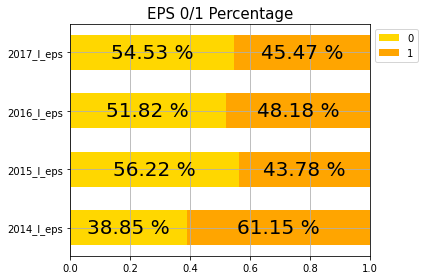

In [ ]:
eps_count = eps_indicator.apply(lambda x:x.value_counts(normalize=True)).T
fig = plt.figure()
ax = fig.add_subplot(111)
ax.barh(eps_count.index, eps_count[0], align='center', height=.6, color='gold',label='0')
ax.barh(eps_count.index, eps_count[1], align='center', height=.6, left=eps_count[0], color='orange',label='1')
ax.set_yticks(eps_count.index)
ax.set_title('EPS 0/1 Percentage', fontsize=15)
ax.grid(True)
ax.set_xlim(0,1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# 將百分比放上
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
        y+height/2, 
        '{:.2f} %'.format(width*100), 
        horizontalalignment='center', 
        verticalalignment='center', fontsize=20)
plt.tight_layout()

接下來針對三表中的資料進行整理，其流程與Y類似。

### X - 資產負債表科目

In [ ]:
# 匯入資料，並展示資料的前五筆
bs_df = pd.read_excel("./BS.xlsx")
bs_df.head()

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,...,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額
0,1101 台泥,2017-12-29,26331218.0,147049.0,25101220.0,0.0,0.0,0.0,27306164.0,755024.0,...,21944766.0,49019510.0,19124539.0,0.0,136348204.0,0.0,0.0,16299012.0,152647216,272557049
1,1102 亞泥,2017-12-29,7739492.0,322080.0,7805406.0,4380928.0,0.0,0.0,18266303.0,3042831.0,...,16125837.0,94196274.0,-1543873.0,0.0,127435565.0,0.0,0.0,18360799.0,145796364,247064348
2,1103 嘉泥,2017-12-29,1803189.0,507148.0,2543683.0,0.0,0.0,0.0,206738.0,65394.0,...,4638766.0,9074455.0,1196784.0,-1149426.0,17511786.0,0.0,0.0,1749054.0,19260840,28317986
3,1104 環泥,2017-12-29,192742.0,0.0,2226289.0,0.0,0.0,0.0,1012020.0,6841.0,...,4793003.0,10109852.0,344008.0,0.0,17036903.0,0.0,0.0,117858.0,17154761,21229208
4,1108 幸福,2017-12-29,251893.0,0.0,151476.0,0.0,0.0,0.0,599362.0,3514.0,...,177528.0,357972.0,-3241.0,0.0,4402119.0,0.0,0.0,26423.0,4428542,7236852


In [ ]:
# 將年份單獨列成一欄
bs_df['year'] = bs_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 將不需要的列去除
bs_df = bs_df[bs_df['year']!='2010']

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
bs_df.columns = [col.strip() for col in bs_df.columns]

接下來對資料進行平減化，由於每個科目的規模相差甚遠，因此採用資產總額對其平減。

In [ ]:
# 將每筆資料除以總資產，採用div()，但由於除數不能用於字符串，因此先將該欄位去除，後續計算完成再利用concat()拼接回去。
tmp = bs_df['資產總額']
bs_df = pd.concat([bs_df[['公司','年月','year']], bs_df.drop(columns=['公司','年月','year']).div(bs_df['資產總額'], axis='rows')], axis=1)
bs_df['資產總額'] = tmp
bs_df.head()

,公司,年月,year,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,...,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額
0,1101 台泥,2017-12-29,2017,0.096608,0.000540,0.092095,0.000000,0.0,0.0,0.100185,...,0.080514,0.179850,0.070167,0.00000,0.500256,0.0,0.0,0.059800,0.560056,1.0
1,1102 亞泥,2017-12-29,2017,0.031326,0.001304,0.031593,0.017732,0.0,0.0,0.073933,...,0.065270,0.381262,-0.006249,0.00000,0.515799,0.0,0.0,0.074316,0.590115,1.0
2,1103 嘉泥,2017-12-29,2017,0.063676,0.017909,0.089826,0.000000,0.0,0.0,0.007301,...,0.163810,0.320448,0.042262,-0.04059,0.618398,0.0,0.0,0.061765,0.680163,1.0
3,1104 環泥,2017-12-29,2017,0.009079,0.000000,0.104869,0.000000,0.0,0.0,0.047671,...,0.225774,0.476224,0.016204,0.00000,0.802522,0.0,0.0,0.005552,0.808074,1.0
4,1108 幸福,2017-12-29,2017,0.034807,0.000000,0.020931,0.000000,0.0,0.0,0.082821,...,0.024531,0.049465,-0.000448,0.00000,0.608292,0.0,0.0,0.003651,0.611943,1.0


如同EPS，由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# bs_account為要展開的科目（其中將可能共線的變數刪除）
bs_account = list(set(bs_df.columns)-set(['公司', '年月', 'year', '流動資產', '非流動資產', '資產總額', '流動負債',
                                         '非流動負債', '負債總額', '股東權益總額', '負債及股東權益總額']))
bs_pivot = bs_df.pivot(index='公司', columns='year', values=bs_account)

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
bs_pivot.columns = ['_'.join(col[::-1]) for col in bs_pivot.columns.values]
bs_pivot.head()

,2011_一年內到期長期負債,2012_一年內到期長期負債,2013_一年內到期長期負債,2014_一年內到期長期負債,2015_一年內到期長期負債,2016_一年內到期長期負債,2017_一年內到期長期負債,2011_採權益法之長期股權投資,2012_採權益法之長期股權投資,2013_採權益法之長期股權投資,...,2015_避險之金融資產－非流動,2016_避險之金融資產－非流動,2017_避險之金融資產－非流動,2011_租賃負債─流動,2012_租賃負債─流動,2013_租賃負債─流動,2014_租賃負債─流動,2015_租賃負債─流動,2016_租賃負債─流動,2017_租賃負債─流動
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.066591,0.079187,0.083693,0.062674,0.065288,0.030578,0.051036,0.036851,0.026214,0.028400,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1102 亞泥,0.034286,0.074321,0.124548,0.057148,0.084122,0.003462,0.037227,0.241217,0.275096,0.258273,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1103 嘉泥,0.040125,0.027238,0.045105,0.033305,0.019720,0.029982,0.024941,0.021798,0.022063,0.014638,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104 環泥,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322554,0.336201,0.355968,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1108 幸福,0.052900,0.042601,0.047991,0.094870,0.051715,0.040593,0.015366,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


接下來進行樣本的篩選，利用前面整理Y變數（更新缺失值去除的部分）去更新company變數。

In [ ]:
company = list(eps_pivot.index)

In [ ]:
bs_pivot = bs_pivot.loc[company].sort_index()
bs_pivot.head()

,2011_一年內到期長期負債,2012_一年內到期長期負債,2013_一年內到期長期負債,2014_一年內到期長期負債,2015_一年內到期長期負債,2016_一年內到期長期負債,2017_一年內到期長期負債,2011_採權益法之長期股權投資,2012_採權益法之長期股權投資,2013_採權益法之長期股權投資,...,2015_避險之金融資產－非流動,2016_避險之金融資產－非流動,2017_避險之金融資產－非流動,2011_租賃負債─流動,2012_租賃負債─流動,2013_租賃負債─流動,2014_租賃負債─流動,2015_租賃負債─流動,2016_租賃負債─流動,2017_租賃負債─流動
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.066591,0.079187,0.083693,0.062674,0.065288,0.030578,0.051036,0.036851,0.026214,0.028400,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1102 亞泥,0.034286,0.074321,0.124548,0.057148,0.084122,0.003462,0.037227,0.241217,0.275096,0.258273,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1103 嘉泥,0.040125,0.027238,0.045105,0.033305,0.019720,0.029982,0.024941,0.021798,0.022063,0.014638,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104 環泥,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322554,0.336201,0.355968,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1108 幸福,0.052900,0.042601,0.047991,0.094870,0.051715,0.040593,0.015366,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


針對資產負債表科目做敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
bs_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2011_一年內到期長期負債,2012_一年內到期長期負債,2013_一年內到期長期負債,2014_一年內到期長期負債,2015_一年內到期長期負債,2016_一年內到期長期負債,2017_一年內到期長期負債,2011_採權益法之長期股權投資,2012_採權益法之長期股權投資,2013_採權益法之長期股權投資,...,2015_避險之金融資產－非流動,2016_避險之金融資產－非流動,2017_避險之金融資產－非流動,2011_租賃負債─流動,2012_租賃負債─流動,2013_租賃負債─流動,2014_租賃負債─流動,2015_租賃負債─流動,2016_租賃負債─流動,2017_租賃負債─流動
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,...,1480.000000,1.480000e+03,1.480000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.020085,0.024475,0.022520,0.020534,0.023264,0.024122,0.020735,0.019770,0.019821,0.021113,...,0.000001,1.318742e-08,3.040957e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.039356,0.044932,0.044902,0.042397,0.049402,0.052010,0.043081,0.061400,0.059967,0.064778,...,0.000036,3.996697e-07,8.785886e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.002462,0.003810,0.002389,0.002166,0.002601,0.002188,0.001303,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.023659,0.031775,0.026930,0.023814,0.026770,0.026909,0.023671,0.009638,0.010444,0.011287,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90%,0.062122,0.073440,0.066287,0.063491,0.065086,0.066712,0.059743,0.050607,0.054060,0.056914,...,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


若要分年度展示，可以先將column進行排序，再進行敘述性統計，採用sort_index(axis=1)。

In [ ]:
bs_pivot.sort_index(axis=1).describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2011_一年內到期長期負債,2011_不動產廠房及設備,2011_使用權資產,2011_保留盈餘,2011_共同控制下前手權益,2011_其他應付款,2011_其他應收款,2011_其他權益,2011_其他長期借款－非流動,2011_其他非流動資產,...,2017_遞延貸項,2017_遞延資產合計,2017_避險之金融負債－流動,2017_避險之金融負債－非流動,2017_避險之金融資產－流動,2017_避險之金融資產－非流動,2017_銀行借款－非流動,2017_非控制權益,2017_預付投資款,2017_預收股款
count,1480.000000,1480.000000,0.0,1480.000000,1478.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,...,1480.000000,1480.000000,1480.000000,1.480000e+03,1480.000000,1.480000e+03,1480.000000,1480.000000,1480.000000,1480.000000
mean,0.020085,0.284199,NaN,0.034362,0.0,0.049826,0.008324,0.013817,0.001890,0.034316,...,0.000002,0.010748,0.000012,2.337516e-07,0.000008,3.040957e-07,0.062615,0.019582,0.000245,0.000331
std,0.039356,0.185163,NaN,0.959092,0.0,0.045971,0.033108,0.079051,0.011713,0.072405,...,0.000044,0.015858,0.000253,8.226736e-06,0.000208,8.785886e-06,0.098371,0.043145,0.002731,0.006999
min,0.000000,0.000085,NaN,-31.671830,0.0,0.000000,0.000000,-2.294233,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-0.173352,0.000000,0.000000
1%,0.000000,0.002286,NaN,-1.281245,0.0,0.000000,0.000000,-0.065249,0.000000,0.000008,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-0.003210,0.000000,0.000000
10%,0.000000,0.043359,NaN,-0.115341,0.0,0.011178,0.000000,-0.012153,0.000000,0.001214,...,0.000000,0.000039,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.136495,NaN,0.024581,0.0,0.023890,0.000000,-0.001166,0.000000,0.003449,...,0.000000,0.002315,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.002462,0.267469,NaN,0.104696,0.0,0.041470,0.001759,0.003000,0.000000,0.010794,...,0.000000,0.006443,0.000000,0.000000e+00,0.000000,0.000000e+00,0.010351,0.000026,0.000000,0.000000
75%,0.023659,0.411549,NaN,0.190599,0.0,0.064097,0.006739,0.021642,0.000000,0.034185,...,0.000000,0.013240,0.000000,0.000000e+00,0.000000,0.000000e+00,0.093619,0.019055,0.000000,0.000000
90%,0.062122,0.530147,NaN,0.284081,0.0,0.091249,0.017697,0.051499,0.000254,0.080453,...,0.000000,0.026000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.200881,0.067096,0.000000,0.000000


從敘述性統計中可以發現有些欄位是整欄都是缺失值，經查證該科目為2017年以後IFRS9以及IFRS15才使用的科目（例如：合約資產、合約負債以及使用權資產等等），可以直接將該科目刪除。其餘的缺失值則視為公司沒有該科目，即補數值0。

In [ ]:
# 當欄位全部為缺失值時將其刪除
bs_pivot.dropna(axis=1, how='all', inplace=True)

In [ ]:
# 將所有缺失值補為0
bs_pivot.fillna(0, inplace=True)

In [ ]:
# 確認是否還有缺失值
bs_pivot[bs_pivot.isnull().sum(axis=1)!=0]

,2011_一年內到期長期負債,2012_一年內到期長期負債,2013_一年內到期長期負債,2014_一年內到期長期負債,2015_一年內到期長期負債,2016_一年內到期長期負債,2017_一年內到期長期負債,2011_採權益法之長期股權投資,2012_採權益法之長期股權投資,2013_採權益法之長期股權投資,...,2015_透過損益按公允價值衡量之金融資產－非流動,2016_透過損益按公允價值衡量之金融資產－非流動,2017_透過損益按公允價值衡量之金融資產－非流動,2011_避險之金融資產－非流動,2012_避險之金融資產－非流動,2013_避險之金融資產－非流動,2014_避險之金融資產－非流動,2015_避險之金融資產－非流動,2016_避險之金融資產－非流動,2017_避險之金融資產－非流動
公司,,,,,,,,,,,,,,,,,,,,,


### X - 損益表科目

In [ ]:
# 匯入資料，並展示資料的前五筆
is_df = pd.read_excel("./IS.xlsx")
is_df.head()

,公司,年月,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,...,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利
0,1101 台泥,2017-12-29,98311776.0,79398862.0,18912914.0,0.0,18912914.0,4950029.0,32399.0,NaN,...,17775812.0,2523760.0,0.0,3738370.0,0.0,7594247.0,3739270.0,15747968.0,22211761.0,10983992.0
1,1102 亞泥,2017-12-29,69700034.0,59529016.0,10171018.0,-540.0,10170478.0,2733762.0,0.0,NaN,...,7895746.0,889334.0,0.0,3139297.0,0.0,5470384.0,3147654.0,10271234.0,15448825.0,6581964.0
2,1103 嘉泥,2017-12-29,2095607.0,1813286.0,282321.0,0.0,282321.0,511805.0,0.0,NaN,...,3538372.0,164255.0,0.0,643555.0,0.0,895198.0,644300.0,1182543.0,1539621.0,-307313.0
3,1104 環泥,2017-12-29,4405376.0,3867468.0,537908.0,0.0,537908.0,387681.0,85467.0,NaN,...,1533947.0,-22487.0,0.0,653609.0,0.0,1411666.0,654879.0,1442996.0,1546607.0,1360132.0
4,1108 幸福,2017-12-29,3434454.0,3305953.0,128501.0,0.0,128501.0,221218.0,0.0,NaN,...,-126733.0,-1968.0,0.0,404738.0,0.0,-101111.0,404738.0,-88278.0,189652.0,-101866.0


In [ ]:
# 將年份單獨列成一欄
is_df['year'] = is_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
is_df.columns = [col.strip() for col in is_df.columns]

接下來對資料進行平減化，由於每個科目的規模相差甚遠，因此採用營業收入淨額對其平減。

In [ ]:
# 將每筆資料除以總資產，採用div()，但由於除數不能用於字符串，因此先將該欄位去除，後續計算完成再利用concat()拼接回去。
is_df = pd.concat([is_df[['公司','年月','year']], is_df.drop(columns=['公司','年月','year']).div(is_df['營業收入淨額'], axis='rows')], axis=1)
is_df.head()

,公司,年月,year,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,...,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利
0,1101 台泥,2017-12-29,2017,1.0,0.807623,0.192377,0.000000,0.192377,0.050350,0.000330,...,0.180811,0.025671,0.0,0.038026,0.0,0.077247,0.038035,0.160184,0.225932,0.111726
1,1102 亞泥,2017-12-29,2017,1.0,0.854074,0.145926,-0.000008,0.145918,0.039222,0.000000,...,0.113282,0.012759,0.0,0.045040,0.0,0.078485,0.045160,0.147363,0.221647,0.094433
2,1103 嘉泥,2017-12-29,2017,1.0,0.865280,0.134720,0.000000,0.134720,0.244228,0.000000,...,1.688471,0.078381,0.0,0.307097,0.0,0.427178,0.307453,0.564296,0.734690,-0.146646
3,1104 環泥,2017-12-29,2017,1.0,0.877897,0.122103,0.000000,0.122103,0.088002,0.019401,...,0.348199,-0.005104,0.0,0.148366,0.0,0.320442,0.148655,0.327553,0.351073,0.308744
4,1108 幸福,2017-12-29,2017,1.0,0.962585,0.037415,0.000000,0.037415,0.064411,0.000000,...,-0.036900,-0.000573,0.0,0.117846,0.0,-0.029440,0.117846,-0.025704,0.055220,-0.029660


如同EPS，由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# is_account為要展開的科目（其中將可能共線的變數刪除）
is_account = list(set(is_df.columns)-set(['公司', '年月', 'year', '營業收入淨額', '營業利益', '營業外收入及支出', '稅前淨利',
                                         '合併總損益', '本期綜合損益總額', '加權平均股數', '加權平均股數－稀釋', '稅前息前淨利',
                                         '稅前息前折舊前淨利']))
is_pivot = is_df.pivot(index='公司', columns='year', values=is_account)

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
is_pivot.columns = ['_'.join(col[::-1]) for col in is_pivot.columns.values]
is_pivot.head()

,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本,2012_已實現銷貨毛利,2013_已實現銷貨毛利,2014_已實現銷貨毛利,2015_已實現銷貨毛利,...,2014_金融資產重分類淨損益,2015_金融資產重分類淨損益,2016_金融資產重分類淨損益,2017_金融資產重分類淨損益,2012_歸屬非控制權益淨利（損）,2013_歸屬非控制權益淨利（損）,2014_歸屬非控制權益淨利（損）,2015_歸屬非控制權益淨利（損）,2016_歸屬非控制權益淨利（損）,2017_歸屬非控制權益淨利（損）
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.023954,0.016454,0.016118,0.020002,0.021402,0.019563,0.156100,0.196582,0.210204,0.155083,...,NaN,NaN,NaN,NaN,0.019472,0.043859,0.048637,0.012272,0.027730,0.027754
1102 亞泥,0.027805,0.023374,0.021467,0.024859,0.026880,0.025424,0.096257,0.128862,0.143269,0.106487,...,NaN,NaN,NaN,NaN,0.011914,0.023471,0.019880,0.001120,0.012101,0.017167
1103 嘉泥,0.035613,0.040141,0.049031,0.080037,0.061025,0.048196,0.063130,0.055044,0.055714,-0.038120,...,NaN,NaN,NaN,NaN,0.020386,0.004184,0.009509,-0.002900,-0.004803,0.039182
1104 環泥,0.000532,0.001293,0.001743,0.002826,0.003620,0.004036,0.068461,0.089116,0.093532,0.104103,...,NaN,NaN,NaN,NaN,0.000597,0.001110,-0.001396,-0.001864,-0.003951,-0.005024
1108 幸福,0.019170,0.014241,0.011094,0.008489,0.007349,0.008948,0.083630,0.111386,0.145528,0.180482,...,NaN,NaN,NaN,NaN,-0.004436,-0.003415,-0.002457,-0.001473,-0.000060,-0.000573


接下來進行樣本的篩選，利用前面整理X變數更新得到的company變數。

In [ ]:
is_pivot = is_pivot.loc[company].sort_index()
is_pivot.head()

,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本,2012_已實現銷貨毛利,2013_已實現銷貨毛利,2014_已實現銷貨毛利,2015_已實現銷貨毛利,...,2014_金融資產重分類淨損益,2015_金融資產重分類淨損益,2016_金融資產重分類淨損益,2017_金融資產重分類淨損益,2012_歸屬非控制權益淨利（損）,2013_歸屬非控制權益淨利（損）,2014_歸屬非控制權益淨利（損）,2015_歸屬非控制權益淨利（損）,2016_歸屬非控制權益淨利（損）,2017_歸屬非控制權益淨利（損）
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.023954,0.016454,0.016118,0.020002,0.021402,0.019563,0.156100,0.196582,0.210204,0.155083,...,NaN,NaN,NaN,NaN,0.019472,0.043859,0.048637,0.012272,0.027730,0.027754
1102 亞泥,0.027805,0.023374,0.021467,0.024859,0.026880,0.025424,0.096257,0.128862,0.143269,0.106487,...,NaN,NaN,NaN,NaN,0.011914,0.023471,0.019880,0.001120,0.012101,0.017167
1103 嘉泥,0.035613,0.040141,0.049031,0.080037,0.061025,0.048196,0.063130,0.055044,0.055714,-0.038120,...,NaN,NaN,NaN,NaN,0.020386,0.004184,0.009509,-0.002900,-0.004803,0.039182
1104 環泥,0.000532,0.001293,0.001743,0.002826,0.003620,0.004036,0.068461,0.089116,0.093532,0.104103,...,NaN,NaN,NaN,NaN,0.000597,0.001110,-0.001396,-0.001864,-0.003951,-0.005024
1108 幸福,0.019170,0.014241,0.011094,0.008489,0.007349,0.008948,0.083630,0.111386,0.145528,0.180482,...,NaN,NaN,NaN,NaN,-0.004436,-0.003415,-0.002457,-0.001473,-0.000060,-0.000573


針對損益表科目做敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
is_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本,2012_已實現銷貨毛利,2013_已實現銷貨毛利,2014_已實現銷貨毛利,2015_已實現銷貨毛利,...,2014_金融資產重分類淨損益,2015_金融資產重分類淨損益,2016_金融資產重分類淨損益,2017_金融資產重分類淨損益,2012_歸屬非控制權益淨利（損）,2013_歸屬非控制權益淨利（損）,2014_歸屬非控制權益淨利（損）,2015_歸屬非控制權益淨利（損）,2016_歸屬非控制權益淨利（損）,2017_歸屬非控制權益淨利（損）
count,1477.000000,1477.000000,1477.000000,1478.000000,1480.000000,1480.000000,1477.000000,1477.000000,1477.000000,1478.000000,...,0.0,0.0,0.0,0.0,1477.000000,1477.000000,1477.000000,1478.000000,1480.000000,1480.000000
mean,0.037500,0.014509,0.012594,0.020154,0.012420,0.015196,0.218085,0.223451,0.234263,0.229912,...,NaN,NaN,NaN,NaN,-0.001953,-0.001298,0.002852,-0.006568,-0.002285,-0.000389
std,1.038504,0.249160,0.107406,0.389905,0.095710,0.108578,0.204903,0.203257,0.191549,0.215505,...,NaN,NaN,NaN,NaN,0.048182,0.039419,0.144510,0.109537,0.053484,0.043624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.192323,-3.103641,-1.611837,-2.628872,...,NaN,NaN,NaN,NaN,-1.131435,-0.944255,-1.127411,-2.439909,-1.381799,-0.695737
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.272326,-0.157501,-0.125925,-0.262136,...,NaN,NaN,NaN,NaN,-0.046861,-0.043810,-0.051180,-0.062696,-0.053207,-0.079312
10%,0.000014,0.000023,0.000007,0.000005,0.000003,0.000011,0.039113,0.049325,0.058123,0.048858,...,NaN,NaN,NaN,NaN,-0.002959,-0.002963,-0.002435,-0.003977,-0.003558,-0.002429
25%,0.000781,0.000756,0.000790,0.000733,0.000720,0.000778,0.102591,0.111198,0.118847,0.123515,...,NaN,NaN,NaN,NaN,-0.000004,0.000000,0.000000,-0.000004,-0.000012,0.000000
50%,0.003322,0.003209,0.003189,0.003280,0.003195,0.003306,0.189167,0.194990,0.203798,0.208796,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008495,0.008205,0.008216,0.008413,0.008646,0.008417,0.313423,0.312393,0.317435,0.319699,...,NaN,NaN,NaN,NaN,0.000001,0.000058,0.000114,0.000034,0.000169,0.000281
90%,0.018038,0.018297,0.017884,0.020219,0.020454,0.020167,0.448022,0.442582,0.458458,0.460754,...,NaN,NaN,NaN,NaN,0.003227,0.003381,0.004183,0.003736,0.005577,0.006477


從敘述性統計中可以發現有些欄位是整欄都是缺失值，經查證該科目為2017年以後IFRS9以及IFRS15才使用的科目（例如：合約資產、合約負債以及使用權資產等等），可以直接將該科目刪除。其餘的缺失值則視為公司沒有該科目，即補數值0。

In [ ]:
# 當欄位全部為缺失值時將其刪除
is_pivot.dropna(axis=1, how='all', inplace=True)

In [ ]:
# 將所有缺失值補為0
is_pivot.fillna(0, inplace=True)

In [ ]:
# 確認是否還有缺失值
is_pivot[is_pivot.isnull().sum(axis=1)!=0]

,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本,2012_已實現銷貨毛利,2013_已實現銷貨毛利,2014_已實現銷貨毛利,2015_已實現銷貨毛利,...,2014_不重分類至損益之項目－OCI,2015_不重分類至損益之項目－OCI,2016_不重分類至損益之項目－OCI,2017_不重分類至損益之項目－OCI,2012_歸屬非控制權益淨利（損）,2013_歸屬非控制權益淨利（損）,2014_歸屬非控制權益淨利（損）,2015_歸屬非控制權益淨利（損）,2016_歸屬非控制權益淨利（損）,2017_歸屬非控制權益淨利（損）
公司,,,,,,,,,,,,,,,,,,,,,


另外，從敘述性統計中發現有些值為inf，經查證發現主要原因為沒有營收資料，因此當營收為分母時導致科目為inf，將該公司的資料直接刪除。

In [ ]:
# 判斷哪些公司有年度缺少營收資料
set(is_pivot[np.isinf(is_pivot).values].index)

{'4147 中裕', '4174 浩鼎', '4188 安克', '4192 杏國'}

In [ ]:
is_pivot.drop(list(set(is_pivot[np.isinf(is_pivot).values].index)), inplace=True)

### X - 現金流量表科目

In [ ]:
# 匯入資料，並展示資料的前五筆
cf_df = pd.read_excel("./CF.xlsx")
cf_df.head()

,公司,年月,來自營運之現金流量,投資活動之現金流量,籌資活動之現金流量
0,1101 台泥,2017-12-29,12310560.0,1055604.0,-14892479.0
1,1102 亞泥,2017-12-29,8139048.0,-6784797.0,-779555.0
2,1103 嘉泥,2017-12-29,403390.0,124980.0,-950610.0
3,1104 環泥,2017-12-29,646339.0,-180463.0,-470396.0
4,1108 幸福,2017-12-29,81037.0,249673.0,-291609.0


In [ ]:
# 將年份單獨列成一欄
cf_df['year'] = cf_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
cf_df.columns = [col.strip() for col in cf_df.columns]

接下來對資料進行平減化，由於每個科目的規模相差甚遠，因此採用資產總額對其平減。

In [ ]:
cf_df = pd.merge(cf_df, bs_df[['公司', 'year', '資產總額']], on=['公司', 'year'], how='left')

In [ ]:
# 將每筆資料除以總資產，採用div()，但由於除數不能用於字符串，因此先將該欄位去除，後續計算完成再利用concat()拼接回去。
pd.concat([cf_df[['公司','年月','year']], cf_df.drop(columns=['公司','年月','year']).div(cf_df['資產總額'], axis='rows')], axis=1)

,公司,年月,year,來自營運之現金流量,投資活動之現金流量,籌資活動之現金流量,資產總額
0,1101 台泥,2017-12-29,2017,0.045167,0.003873,-0.054640,1.0
1,1102 亞泥,2017-12-29,2017,0.032943,-0.027462,-0.003155,1.0
2,1103 嘉泥,2017-12-29,2017,0.014245,0.004413,-0.033569,1.0
3,1104 環泥,2017-12-29,2017,0.030446,-0.008501,-0.022158,1.0
4,1108 幸福,2017-12-29,2017,0.011198,0.034500,-0.040295,1.0
...,...,...,...,...,...,...,...
10275,9951 皇田,2012-12-28,2012,0.156052,0.009314,-0.124012,1.0
10276,9955 佳龍,2012-12-28,2012,0.098862,-0.072931,-0.020909,1.0
10277,9958 世紀鋼,2012-12-28,2012,-0.043691,-0.042862,0.078335,1.0
10278,9960 邁達康,2012-12-28,2012,0.056004,0.056308,-0.000316,1.0


如同EPS，由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# cf_account為要展開的科目
cf_account = list(set(cf_df.columns)-set(['公司', '年月', 'year', '資產總額']))

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
cf_pivot = cf_df.pivot(index='公司', columns='year', values=cf_account)
cf_pivot.columns = ['_'.join(col[::-1]) for col in cf_pivot.columns.values]
cf_pivot.head()

,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量
公司,,,,,,,,,,,,,,,,,,
1101 台泥,-9932035.0,-1248644.0,-3015765.0,-7833403.0,54767.0,1055604.0,-12251656.0,-20772849.0,-11730774.0,-5046590.0,-28895952.0,-14892479.0,25434756.0,21973605.0,19904673.0,21763392.0,18750155.0,12310560.0
1102 亞泥,-8961889.0,-11256192.0,-12619151.0,-2360243.0,2330984.0,-6784797.0,-7515198.0,6919806.0,-4566862.0,-12987242.0,-18325536.0,-779555.0,14167455.0,14781266.0,10642592.0,13592303.0,12817431.0,8139048.0
1103 嘉泥,-1363371.0,881881.0,-2234527.0,-775173.0,3214197.0,124980.0,889464.0,-1198763.0,1561084.0,-925916.0,-3066744.0,-950610.0,748670.0,-727919.0,463080.0,303390.0,414899.0,403390.0
1104 環泥,-172185.0,-417900.0,-470658.0,-613010.0,-444014.0,-180463.0,-338532.0,43120.0,-222743.0,-235576.0,-494776.0,-470396.0,74512.0,548411.0,659966.0,847608.0,741025.0,646339.0
1108 幸福,129371.0,-96894.0,-199779.0,-134964.0,-260675.0,249673.0,-437045.0,-403822.0,-588616.0,-924963.0,7594.0,-291609.0,273329.0,621452.0,831155.0,1018144.0,246301.0,81037.0


接下來進行樣本的篩選，利用前面整理X變數更新得到的company變數。

In [ ]:
cf_pivot = cf_pivot.loc[company].sort_index()
cf_pivot.head()

,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量
公司,,,,,,,,,,,,,,,,,,
1101 台泥,-9932035.0,-1248644.0,-3015765.0,-7833403.0,54767.0,1055604.0,-12251656.0,-20772849.0,-11730774.0,-5046590.0,-28895952.0,-14892479.0,25434756.0,21973605.0,19904673.0,21763392.0,18750155.0,12310560.0
1102 亞泥,-8961889.0,-11256192.0,-12619151.0,-2360243.0,2330984.0,-6784797.0,-7515198.0,6919806.0,-4566862.0,-12987242.0,-18325536.0,-779555.0,14167455.0,14781266.0,10642592.0,13592303.0,12817431.0,8139048.0
1103 嘉泥,-1363371.0,881881.0,-2234527.0,-775173.0,3214197.0,124980.0,889464.0,-1198763.0,1561084.0,-925916.0,-3066744.0,-950610.0,748670.0,-727919.0,463080.0,303390.0,414899.0,403390.0
1104 環泥,-172185.0,-417900.0,-470658.0,-613010.0,-444014.0,-180463.0,-338532.0,43120.0,-222743.0,-235576.0,-494776.0,-470396.0,74512.0,548411.0,659966.0,847608.0,741025.0,646339.0
1108 幸福,129371.0,-96894.0,-199779.0,-134964.0,-260675.0,249673.0,-437045.0,-403822.0,-588616.0,-924963.0,7594.0,-291609.0,273329.0,621452.0,831155.0,1018144.0,246301.0,81037.0


針對現金流量表科目做敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
cf_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量
count,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03
mean,-1.053198e+06,-1.136134e+06,-1.095402e+06,-1.018648e+06,-1.239269e+06,-1.129196e+06,-2.118447e+05,-1.217984e+05,-3.446984e+05,-8.148838e+05,-5.452306e+05,-3.260980e+05,1.444428e+06,1.590817e+06,1.645593e+06,1.937653e+06,1.950274e+06,1.581852e+06
std,8.060079e+06,8.959425e+06,8.625812e+06,7.008859e+06,1.270705e+07,1.004361e+07,4.385962e+06,3.381040e+06,5.387473e+06,7.463436e+06,5.988675e+06,8.290956e+06,1.005254e+07,1.156306e+07,1.347157e+07,1.649906e+07,1.613425e+07,1.659898e+07
min,-2.693177e+08,-2.810542e+08,-2.824206e+08,-2.172458e+08,-3.954397e+08,-3.361649e+08,-1.081457e+08,-6.066204e+07,-1.582185e+08,-1.911784e+08,-1.578002e+08,-2.156976e+08,-1.749644e+07,-1.623146e+07,-1.342420e+07,-1.305248e+07,-1.340052e+07,-3.934131e+07
1%,-2.005585e+07,-2.068065e+07,-1.915265e+07,-2.138704e+07,-2.084828e+07,-2.134686e+07,-8.624794e+06,-9.273277e+06,-1.165132e+07,-1.887969e+07,-1.615406e+07,-1.338702e+07,-2.040972e+06,-2.223975e+06,-2.847562e+06,-1.594716e+06,-1.926451e+06,-2.196812e+06
10%,-1.446668e+06,-1.364875e+06,-1.453199e+06,-1.446884e+06,-1.299244e+06,-1.575362e+06,-7.748645e+05,-7.898785e+05,-8.009918e+05,-1.170323e+06,-1.162121e+06,-8.839859e+05,-9.834130e+04,-1.353195e+05,-1.659209e+05,-1.112258e+05,-9.392390e+04,-2.084740e+05
25%,-3.711468e+05,-4.026330e+05,-4.371492e+05,-4.231050e+05,-3.798992e+05,-3.986090e+05,-2.730210e+05,-2.448175e+05,-2.254140e+05,-3.318525e+05,-3.585818e+05,-2.562228e+05,1.633125e+04,1.970900e+04,2.220000e+03,3.513100e+04,3.498250e+04,-9.548500e+03
50%,-9.068700e+04,-1.045655e+05,-1.166405e+05,-9.720600e+04,-8.849600e+04,-9.246200e+04,-4.557500e+04,-4.608750e+04,-3.035200e+04,-7.430200e+04,-7.777650e+04,-3.606200e+04,1.645980e+05,1.913755e+05,1.655025e+05,2.348850e+05,2.279945e+05,1.592245e+05
75%,-1.064050e+04,-1.208500e+04,-1.359700e+04,-6.132500e+03,-2.149000e+03,-4.174250e+03,8.095500e+04,1.078605e+05,1.387895e+05,5.019475e+04,3.292275e+04,1.111282e+05,5.649545e+05,6.262515e+05,6.000848e+05,7.431488e+05,7.689195e+05,5.645492e+05
90%,4.002480e+04,5.770630e+04,4.163860e+04,7.304150e+04,1.147885e+05,1.102836e+05,5.244846e+05,6.740923e+05,5.995042e+05,4.065979e+05,3.570691e+05,5.720354e+05,1.959114e+06,2.064868e+06,1.827033e+06,2.106604e+06,2.323915e+06,1.819719e+06


從敘述性統計中可以發現並沒有缺失值，不需多做處理。

In [ ]:
# 確認是否有缺失值
cf_pivot[cf_pivot.isnull().sum(axis=1)!=0]

,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量
公司,,,,,,,,,,,,,,,,,,


### 合併以及整理X資料

將所有的X變量整理成一張表，其中包括資產負債表科目（bs_pivot）、損益表科目（is_pivot）、現金流量表科目（cf_pivot）以及調整後的EPS（eps_pivot）。

In [ ]:
# 由於每個表再處理缺失值方式不一樣，因此可能導致樣本量不同，所以用inner join來留下交集的數據。
input_data = pd.concat([bs_pivot, is_pivot, cf_pivot, eps_pivot], axis=1, join='inner')
input_data.head()

,2011_一年內到期長期負債,2012_一年內到期長期負債,2013_一年內到期長期負債,2014_一年內到期長期負債,2015_一年內到期長期負債,2016_一年內到期長期負債,2017_一年內到期長期負債,2011_採權益法之長期股權投資,2012_採權益法之長期股權投資,2013_採權益法之長期股權投資,...,2016_來自營運之現金流量,2017_來自營運之現金流量,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.066591,0.079187,0.083693,0.062674,0.065288,0.030578,0.051036,0.036851,0.026214,0.028400,...,18750155.0,12310560.0,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441
1102 亞泥,0.034286,0.074321,0.124548,0.057148,0.084122,0.003462,0.037227,0.241217,0.275096,0.258273,...,12817431.0,8139048.0,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000
1103 嘉泥,0.040125,0.027238,0.045105,0.033305,0.019720,0.029982,0.024941,0.021798,0.022063,0.014638,...,414899.0,403390.0,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000
1104 環泥,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322554,0.336201,0.355968,...,741025.0,646339.0,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000
1108 幸福,0.052900,0.042601,0.047991,0.094870,0.051715,0.040593,0.015366,0.000000,0.000000,0.000000,...,246301.0,81037.0,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000


最後，將資料中其他年度沒有的欄位刪除，該欄位對於分類的模型沒有任何的幫助，只會造成干擾而已。

In [ ]:
input_data.drop(columns=['2017_預期信用減損（損失）利益－營業費用', '2017_預期信用減損（損失）利益'], inplace=True)

In [ ]:
# Duke: 只挑電子資訊業
selected_industry = np.array([])

for i in input_data.index:
  if i[0:2] in ["23", "24", "30"]:
    selected_industry = np.append(selected_industry, i)

input_data = input_data.filter(items = selected_industry, axis=0)

## 資料拆分（Data Spliting）& 模型訓練與評估

### 不採用驗證資料集（Validation Dataset）

### 嘗試一

嘗試一不採用驗證資料集，使用2012-2014的3個資產負債表以及2013-2014的2個損益表及2個現金流量表資料為訓練資料集，以2015的每股盈餘增長為標籤（Label）。最終，利用2013-2015的3個資產負債表以及2014-2015的2個損益表及2個現金流量表資料去預測2016的每股盈餘增長。

In [ ]:
account_name = list(set(['_'.join(col.split('_')[1:]) for col in input_data.columns]))

In [ ]:
xtrain1 = pd.DataFrame(index=input_data.index)
year = 2015
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtrain1["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtrain1["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtrain1["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtrain1["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtrain1["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytrain1 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [ ]:
xtest1 = pd.DataFrame(index=input_data.index)
year = 2016
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtest1["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtest1["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest1["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtest1["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest1["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytest1 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

#### 隨機森林模型（Random Forest）

模型的參數非常重要，且要顧慮到是否能夠普遍性的使用在其他資料上，否則將出現過度擬合（Overfitting）的問題，即在訓練資料上正確率很高，但在測試資料上卻很差，如下面所示：

In [ ]:
rfModel1 = RandomForestClassifier(n_estimators=500, max_samples=1.0, min_samples_leaf=1, random_state=0)
rfModel1.fit(xtrain1, ytrain1)
print('Training Dataset Accuracy Score: %.4f' % (np.mean([i==j for i,j in zip(rfModel1.predict(xtrain1), ytrain1)])))
print('Testing Dataset Accuracy Score: %.4f' % (np.mean([i==j for i,j in zip(rfModel1.predict(xtest1), ytest1)])))

Training Dataset Accuracy Score: 1.0000
Testing Dataset Accuracy Score: 0.6341


要做好參數的調整，使用網格搜索（Grid Search）的方式來進行參數的自動調整。

In [ ]:
# 設定要調整的參數以及其選項
rfModel_param_grid = {
    'bootstrap': [True],
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [10, 20, 30 ,40, 'log2', 'sqrt']
}

In [ ]:
start = time.time()
best_score = 0
for estimator in rfModel_param_grid['n_estimators']:
    for min_samples_leaf in rfModel_param_grid['min_samples_leaf']:
        for max_sample in rfModel_param_grid['max_samples']:
            for max_feature in rfModel_param_grid['max_features']:
                rfModel1 = RandomForestClassifier(n_estimators=estimator, max_samples=max_sample, min_samples_leaf=min_samples_leaf,
                                                  max_features=max_feature, bootstrap=True, random_state=0)
                rfModel1.fit(xtrain1, ytrain1)
                score = rfModel1.score(xtrain1, ytrain1)
                if score > best_score:
                    best_score = score
                    best_parameters = {'bootstrap': [True], 
                                       'n_estimators': estimator,
                                       'min_samples_leaf': min_samples_leaf,
                                       'max_samples': max_sample,
                                       'max_features': max_feature}
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Time spent: 642.0754 seconds
Best score: 1.00
Best parameters: {'bootstrap': [True], 'n_estimators': 50, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 10}


In [ ]:
rfModel1 = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], max_samples=best_parameters['max_samples'], 
                                  min_samples_leaf=best_parameters['min_samples_leaf'], max_features=best_parameters['max_features'],
                                  bootstrap=True, random_state=0)
rfModel1.fit(xtrain1, ytrain1)

RandomForestClassifier(max_features=10, max_samples=0.8, n_estimators=50,
                       random_state=0)

中文自行設定教學: https://jdhao.github.io/2017/05/13/guide-on-how-to-use-chinese-with-matplotlib/#use-a-font    
字體下載: https://code.google.com/archive/p/kingfont/downloads


In [ ]:
# 繪製變數重要性function
def plot_importance(tree):
    # 下面這句是設定字型，因為變數是中文，但是python畫圖的default字體會沒辦法顯示中文，所以要先指定
    # 可參考上方教學網址及字體下載網址(範例使用STHeiti Light)
    font = FontProperties(fname='./STHeiti Light.ttc',size=14)
    # 讓變數為key，對應重要性(gini importance)為value
    importance_dict = {}
    for col, gini in zip(tree.feature_names_in_,tree.feature_importances_):
        importance_dict[col] = gini
    
    # 刪去重要性為0的變數，不用畫在圖上
    for var in tree.feature_names_in_:
        if importance_dict[var]==0:
            importance_dict.pop(var)
    
    # 根據重要性由小到大，排列出變數
    sort_col = sorted(importance_dict.items(), key=lambda x:x[1])
    # 取前10高重要性變數
    sort_col_top10 = sort_col[-10:]
    account = [a for (a, i) in sort_col_top10]
    importance = [i for (a, i) in sort_col_top10]

    # Plot 
    plt.title("Feature importances(Random Forest): Gini index")
    plt.barh(account, importance, color="b")
    plt.yticks(range(len(account)), account, fontproperties=font, fontsize=15)
    
    # 增添標籤，在每個bar前方增加該變數的重要性
    for a,b in zip(range(len(importance)), importance):
        plt.text(b+0.0015, a, '%.3f' % b, ha='center', va= 'center', fontsize=10)
    plt.xlim([0,max(importance)+0.005])
    plt.show()

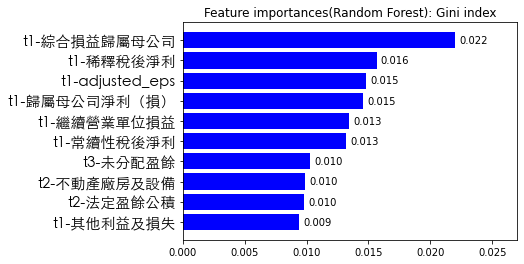

In [ ]:
plot_importance(rfModel1)

Accuracy:  1.0


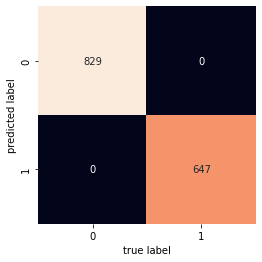

In [ ]:
# 訓練資料集上的結果
ytrain_pred1 = rfModel1.predict(xtrain1)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytrain_pred1, ytrain1)]))
mat = confusion_matrix(ytrain1, ytrain_pred1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

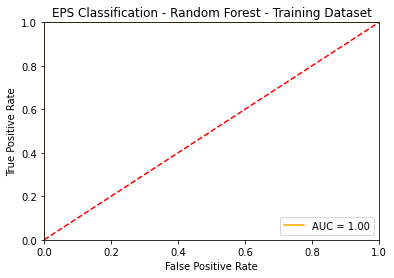

In [ ]:
# 訓練資料集的AUC
fpr, tpr, threshold = roc_curve(ytrain1, ytrain_pred1)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.6138211382113821


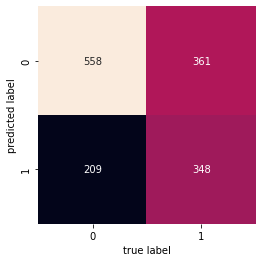

In [ ]:
# 測試資料集上的結果
ytest_pred1 = rfModel1.predict(xtest1)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytest_pred1, ytest1)]))
mat = confusion_matrix(ytest1, ytest_pred1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

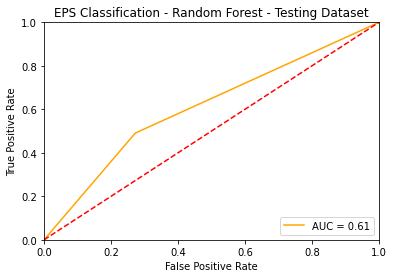

In [ ]:
# 測試資料集的AUC
fpr, tpr, threshold = roc_curve(ytest1, ytest_pred1)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Testing Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對隨機森林模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
# 訓練資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel1.predict_proba(xtrain1)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel1.predict_proba(xtrain1)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel1.predict_proba(xtrain1)]

In [ ]:
print("Training Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytrain1)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytrain1) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytrain1) if type(i)==int]))

Training Dataset
50-50 Accuracy:  1.0
60-40 Accuracy:  1.0
80-20 Accuracy:  1.0


In [ ]:
# 測試資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel1.predict_proba(xtest1)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel1.predict_proba(xtest1)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel1.predict_proba(xtest1)]

In [ ]:
print("Testing Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest1)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest1) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest1) if type(i)==int]))

Testing Dataset
50-50 Accuracy:  0.6138211382113821
60-40 Accuracy:  0.6476683937823834
80-20 Accuracy:  0.6363636363636364


In [ ]:
# 將預測結果存成excel檔
pd.DataFrame(rfModel1.predict_proba(xtest1), index=xtest1.index, columns=['EPS下跌','EPS增加']).to_excel("./RF_test1.xlsx")

#### Xgboost模型

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgbModel_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.8, 1.],
    'min_child_weight': [1, 5, 11]
}

In [ ]:
start = time.time()
best_score = 0
for estimator in xgbModel_param_grid['n_estimators']:
    for max_depth in xgbModel_param_grid['max_depth']:
        for lr in xgbModel_param_grid['learning_rate']:
            for gamma in xgbModel_param_grid['gamma']:
                for colsample_bytree in xgbModel_param_grid['colsample_bytree']:
                    for min_child in xgbModel_param_grid['min_child_weight']:
                        xgbModel1 = XGBClassifier(n_estimators=estimator, learning_rate=lr, max_depth=max_depth,
                                                  gamma=gamma, colsample_bytree=colsample_bytree, 
                                                  min_child_weight=min_child, random_state=0, 
                                                  eval_metric='logloss', use_label_encoder=False)
                        xgbModel1.fit(xtrain1, ytrain1)
                        score = xgbModel1.score(xtrain1, ytrain1)
                        if score > best_score:
                            best_score = score
                            best_parameters = {'n_estimators': estimator,
                                               'max_depth': max_depth,
                                               'learning_rate': lr,
                                               'gamma': gamma,
                                               'colsample_bytree': colsample_bytree,
                                               'min_child_weight': min_child}
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Time spent: 3824.1268 seconds
Best score: 1.00
Best parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5, 'min_child_weight': 1}


In [ ]:
xgbModel1 = XGBClassifier(n_estimators=best_parameters['n_estimators'], learning_rate=best_parameters['learning_rate'],
                          max_depth=best_parameters['max_depth'], gamma=best_parameters['gamma'], 
                          colsample_bytree=best_parameters['colsample_bytree'], min_child_weight=best_parameters['min_child_weight'],
                          random_state=0, eval_metric='logloss', use_label_encoder=False)
xgbModel1.fit(xtrain1, ytrain1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

中文自行設定教學: https://jdhao.github.io/2017/05/13/guide-on-how-to-use-chinese-with-matplotlib/#use-a-font    
字體下載: https://code.google.com/archive/p/kingfont/downloads

In [ ]:
# 繪製變數重要性function
def plot_importance_xgb(train, model):
    # 下面這句是設定字型，因為變數是中文，但是python畫圖的default字體會沒辦法顯示中文，所以要先指定
    # 可參考上方教學網址及字體下載網址(範例使用STHeiti Light)
    font = FontProperties(fname='./STHeiti Light.ttc',size=14)
    # 讓變數為key，對應重要性(gini importance)為value
    importance_dict = {}
    for col, gini in zip(train.columns ,model.feature_importances_):
        importance_dict[col] = gini
    
    # 根據重要性由小到大，排列出變數
    sort_col = sorted(importance_dict.items(), key=lambda x:x[1])
    # 取前10高重要性變數
    sort_col_top10 = sort_col[-10:]
    account = [a for (a, i) in sort_col_top10]
    importance = [i for (a, i) in sort_col_top10]

    # Plot 
    plt.title("Feature importances(XGBoost): Gini index")
    plt.barh(account, importance, color="b")
    plt.yticks(range(len(account)), account, fontproperties=font, fontsize=15)
    
    # 增添標籤，在每個bar前方增加該變數的重要性
    for a,b in zip(range(len(importance)), importance):
        plt.text(b+0.0015, a, '%.3f' % b, ha='center', va= 'center', fontsize=10)
    plt.xlim([0,max(importance)+0.005])
    plt.show()

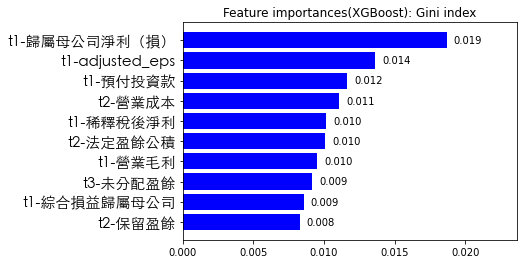

In [ ]:
plot_importance_xgb(xtrain1, xgbModel1)

Accuracy:  1.0


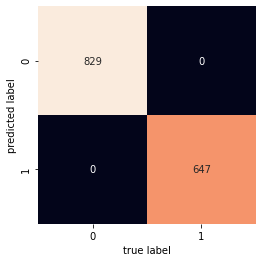

In [ ]:
# 訓練資料集上的結果
ytrain_pred1 = xgbModel1.predict(xtrain1)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytrain_pred1, ytrain1)]))
mat = confusion_matrix(ytrain1, ytrain_pred1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

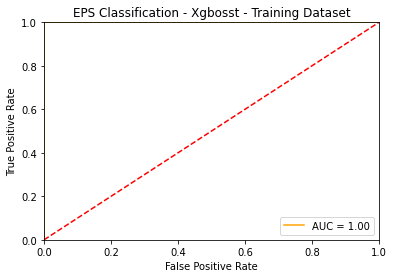

In [ ]:
# 訓練資料集的AUC
fpr, tpr, threshold = roc_curve(ytrain1, ytrain_pred1)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgbosst - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.6212737127371274


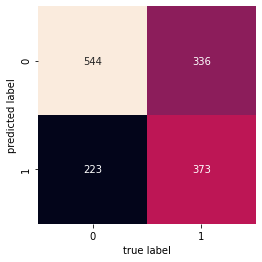

In [ ]:
# 測試資料集上的結果
ytest_pred1 = xgbModel1.predict(xtest1)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytest_pred1, ytest1)]))
mat = confusion_matrix(ytest1, ytest_pred1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

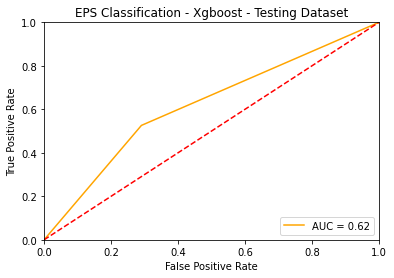

In [ ]:
# 測試資料集的AUC
fpr, tpr, threshold = roc_curve(ytest1, ytest_pred1)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgboost - Testing Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對Xgboost模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
# 訓練資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel1.predict_proba(xtrain1)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel1.predict_proba(xtrain1)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel1.predict_proba(xtrain1)]

In [ ]:
print("Training Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytrain1)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytrain1) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytrain1) if type(i)==int]))

Training Dataset
50-50 Accuracy:  1.0
60-40 Accuracy:  1.0
80-20 Accuracy:  1.0


In [ ]:
# 測試資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel1.predict_proba(xtest1)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel1.predict_proba(xtest1)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel1.predict_proba(xtest1)]

In [ ]:
print("Testing Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest1)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest1) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest1) if type(i)==int]))

Testing Dataset
50-50 Accuracy:  0.6212737127371274
60-40 Accuracy:  0.6501736111111112
80-20 Accuracy:  0.6684684684684684


In [ ]:
# 將預測結果存成excel檔
pd.DataFrame(xgbModel1.predict_proba(xtest1), index=xtest1.index, columns=['EPS下跌','EPS增加']).to_excel("./xgb_test1.xlsx")

### 嘗試二

嘗試二不採用驗證資料集，使用標籤年度的前兩年的3個資產負債表（期初以及期末）以及2個損益表及2個現金流量表資料為訓練資料集，以2014以及2015的每股盈餘增長為標籤。最終，利用2013-2015的3個資產負債表以及2014-2015的2個損益表及2個現金流量表資料去預測2016的每股盈餘增長。

In [ ]:
tmp = pd.DataFrame(index=input_data.index)
years = [2014, 2015]
for num, year in enumerate(years):
    for acc in account_name:
        if acc in bs_account: # bs_account為資產負債表中的科目
            tmp["t3-"+acc] = input_data[str(year-3)+"_"+acc]
            tmp["t2-"+acc] = input_data[str(year-2)+"_"+acc]
            tmp["t1-"+acc] = input_data[str(year-1)+"_"+acc]
        else:
            tmp["t2-"+acc] = input_data[str(year-2)+"_"+acc]
            tmp["t1-"+acc] = input_data[str(year-1)+"_"+acc]
        tmpy = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()
    if num==len(years)-1:
        xtrain2 = pd.concat([xtrain2, tmp], axis=0)
        ytrain2 = pd.concat([ytrain2, tmpy], axis=0)
    else:
        xtrain2 = tmp.copy()  
        ytrain2 = tmpy.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [ ]:
xtest2 = pd.DataFrame(index=input_data.index)
year = 2016
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtest2["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtest2["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest2["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtest2["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest2["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytest2 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

#### 隨機森林模型（Random Forest）

模型的參數非常重要，且要顧慮到是否能夠普遍性的使用在其他資料上，否則將出現過度擬合（Overfitting）的問題，即在訓練資料上正確率很高，但在測試資料上卻很差，如下面所示：

In [ ]:
rfModel2 = RandomForestClassifier(n_estimators=500, max_samples=1.0, min_samples_leaf=1, random_state=0)
rfModel2.fit(xtrain2, ytrain2)
print('Training Dataset Accuracy Score: %.4f' % (np.mean([i==j for i,j in zip(rfModel2.predict(xtrain2), ytrain2)])))
print('Testing Dataset Accuracy Score: %.4f' % (np.mean([i==j for i,j in zip(rfModel2.predict(xtest2), ytest2)])))

Training Dataset Accuracy Score: 1.0000
Testing Dataset Accuracy Score: 0.6430


要做好參數的調整，使用網格搜索（Grid Search）的方式來進行參數的自動調整。

In [ ]:
# 設定要調整的參數以及其選項
rfModel_param_grid = {
    'bootstrap': [True],
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [10, 20, 30 ,40, 'log2', 'sqrt']
}

In [ ]:
start = time.time()
best_score = 0
for estimator in rfModel_param_grid['n_estimators']:
    for min_samples_leaf in rfModel_param_grid['min_samples_leaf']:
        for max_sample in rfModel_param_grid['max_samples']:
            for max_feature in rfModel_param_grid['max_features']:
                rfModel2 = RandomForestClassifier(n_estimators=estimator, max_samples=max_sample, min_samples_leaf=min_samples_leaf,
                                                  max_features=max_feature, bootstrap=True, random_state=0)
                rfModel2.fit(xtrain2, ytrain2)
                score = rfModel2.score(xtrain2, ytrain2)
                if score > best_score:
                    best_score = score
                    best_parameters = {'bootstrap': [True], 
                                       'n_estimators': estimator,
                                       'min_samples_leaf': min_samples_leaf,
                                       'max_samples': max_sample,
                                       'max_features': max_feature}
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Time spent: 1063.1135 seconds
Best score: 1.00
Best parameters: {'bootstrap': [True], 'n_estimators': 50, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 10}


In [ ]:
rfModel2 = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], max_samples=best_parameters['max_samples'], 
                                  min_samples_leaf=best_parameters['min_samples_leaf'], max_features=best_parameters['max_features'],
                                  bootstrap=True, random_state=0)
rfModel2.fit(xtrain2, ytrain2)

RandomForestClassifier(max_features=10, max_samples=0.8, n_estimators=50,
                       random_state=0)

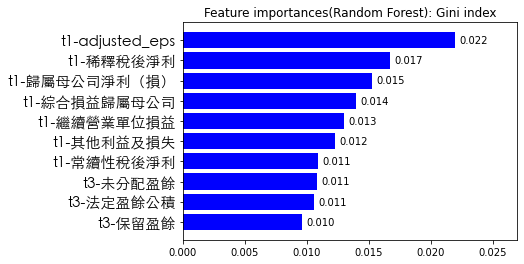

In [ ]:
plot_importance(rfModel2)

Accuracy:  1.0


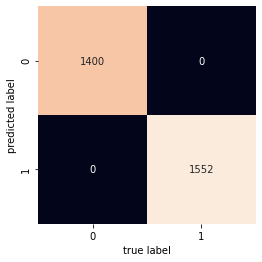

In [ ]:
# 訓練資料集上的結果
ytrain_pred2 = rfModel2.predict(xtrain2)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytrain_pred2, ytrain2)]))
mat = confusion_matrix(ytrain2, ytrain_pred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

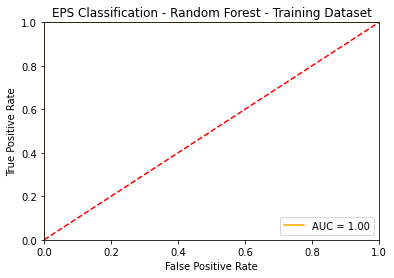

In [ ]:
# 訓練資料集的AUC
fpr, tpr, threshold = roc_curve(ytrain2, ytrain_pred2)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.6205962059620597


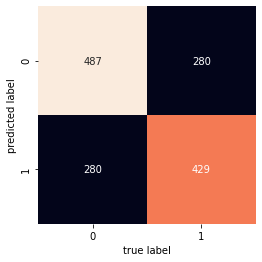

In [ ]:
# 測試資料集上的結果
ytest_pred2 = rfModel2.predict(xtest2)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytest_pred2, ytest2)]))
mat = confusion_matrix(ytest2, ytest_pred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

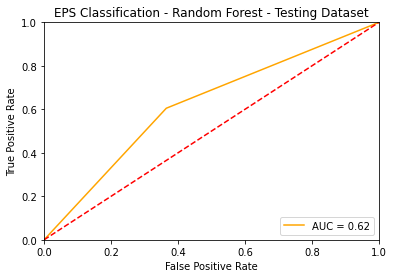

In [ ]:
# 測試資料集的AUC
fpr, tpr, threshold = roc_curve(ytest2, ytest_pred2)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Testing Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對隨機森林模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
# 訓練資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel2.predict_proba(xtrain2)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel2.predict_proba(xtrain2)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel2.predict_proba(xtrain2)]

In [ ]:
print("Training Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytrain2)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytrain2) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytrain2) if type(i)==int]))

Training Dataset
50-50 Accuracy:  1.0
60-40 Accuracy:  1.0
80-20 Accuracy:  1.0


In [ ]:
# 測試資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel2.predict_proba(xtest2)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel2.predict_proba(xtest2)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel2.predict_proba(xtest2)]

In [ ]:
print("Testing Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest2)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest2) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest2) if type(i)==int]))

Testing Dataset
50-50 Accuracy:  0.6205962059620597
60-40 Accuracy:  0.673582295988935
80-20 Accuracy:  0.7741935483870968


In [ ]:
# 將預測結果存成excel檔
pd.DataFrame(rfModel2.predict_proba(xtest2), index=xtest2.index, columns=['EPS下跌','EPS增加']).to_excel("./RF_test2.xlsx")

#### Xgboost模型

In [ ]:
xgbModel_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.8, 1.],
    'min_child_weight': [1, 5, 11]
}

In [ ]:
start = time.time()
best_score = 0
for estimator in xgbModel_param_grid['n_estimators']:
    for max_depth in xgbModel_param_grid['max_depth']:
        for lr in xgbModel_param_grid['learning_rate']:
            for gamma in xgbModel_param_grid['gamma']:
                for colsample_bytree in xgbModel_param_grid['colsample_bytree']:
                    for min_child in xgbModel_param_grid['min_child_weight']:
                        xgbModel2 = XGBClassifier(n_estimators=estimator, learning_rate=lr, max_depth=max_depth,
                                                  gamma=gamma, colsample_bytree=colsample_bytree, 
                                                  min_child_weight=min_child, random_state=0, 
                                                  eval_metric='logloss', use_label_encoder=False)
                        xgbModel2.fit(xtrain2, ytrain2)
                        score = xgbModel2.score(xtrain2, ytrain2)
                        if score > best_score:
                            best_score = score
                            best_parameters = {'n_estimators': estimator,
                                               'max_depth': max_depth,
                                               'learning_rate': lr,
                                               'gamma': gamma,
                                               'colsample_bytree': colsample_bytree,
                                               'min_child_weight': min_child}
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Time spent: 5781.6427 seconds
Best score: 0.99
Best parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0, 'min_child_weight': 1}


In [ ]:
xgbModel2 = XGBClassifier(n_estimators=best_parameters['n_estimators'], learning_rate=best_parameters['learning_rate'],
                          max_depth=best_parameters['max_depth'], gamma=best_parameters['gamma'], 
                          colsample_bytree=best_parameters['colsample_bytree'], min_child_weight=best_parameters['min_child_weight'],
                          random_state=0, eval_metric='logloss', use_label_encoder=False)
xgbModel2.fit(xtrain2, ytrain2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

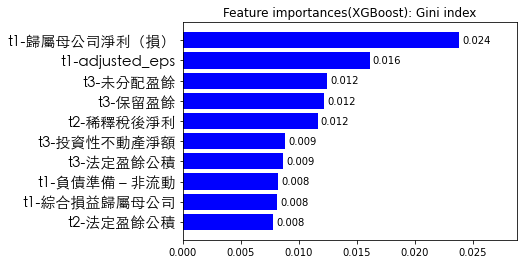

In [ ]:
plot_importance_xgb(xtrain2, xgbModel2)

Accuracy:  0.9908536585365854


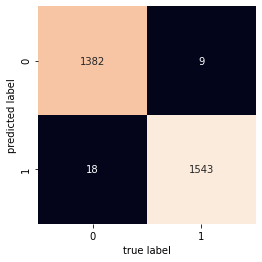

In [ ]:
# 訓練資料集上的結果
ytrain_pred2 = xgbModel2.predict(xtrain2)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytrain_pred2, ytrain2)]))
mat = confusion_matrix(ytrain2, ytrain_pred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

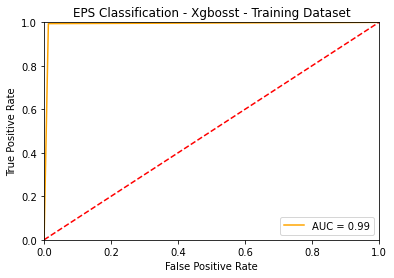

In [ ]:
# 訓練資料集的AUC
fpr, tpr, threshold = roc_curve(ytrain2, ytrain_pred2)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgbosst - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.6266937669376694


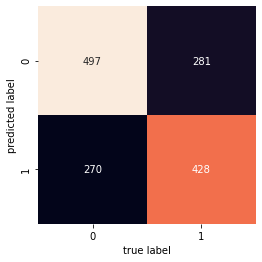

In [ ]:
# 測試資料集上的結果
ytest_pred2 = xgbModel2.predict(xtest2)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytest_pred2, ytest2)]))
mat = confusion_matrix(ytest2, ytest_pred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

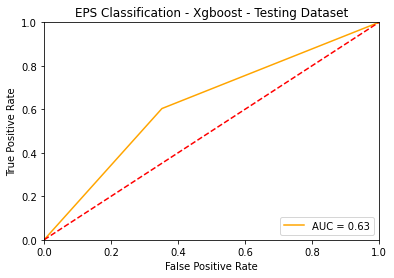

In [ ]:
# 測試資料集的AUC
fpr, tpr, threshold = roc_curve(ytest2, ytest_pred2)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgboost - Testing Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對Xgboost模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
# 訓練資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel2.predict_proba(xtrain2)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel2.predict_proba(xtrain2)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel2.predict_proba(xtrain2)]

In [ ]:
print("Training Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytrain2)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytrain2) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytrain2) if type(i)==int]))

Training Dataset
50-50 Accuracy:  0.9908536585365854
60-40 Accuracy:  0.9985845718329794
80-20 Accuracy:  1.0


In [ ]:
# 測試資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel2.predict_proba(xtest2)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel2.predict_proba(xtest2)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel2.predict_proba(xtest2)]

In [ ]:
print("Testing Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest2)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest2) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest2) if type(i)==int]))

Testing Dataset
50-50 Accuracy:  0.6266937669376694
60-40 Accuracy:  0.6592797783933518
80-20 Accuracy:  0.7387862796833773


In [ ]:
# 將預測結果存成excel檔
pd.DataFrame(xgbModel2.predict_proba(xtest2), index=xtest2.index, columns=['EPS下跌','EPS增加']).to_excel("./xgb_test2.xlsx")

### 採用驗證資料集

### 嘗試三

嘗試三採用驗證資料集，使用2011-2013的3個資產負債表以及2012-2013的2個損益表及2個現金流量表資料為訓練資料集，以2014的每股盈餘增長為標籤。以2012-2014的3個資產負債表以及2013-2014的2個損益表及2個現金流量表資料為驗證資料集，並以2015的每股盈餘增長為標籤。最終，利用2013-2015的3個資產負債表以及2014-2015的2個損益表及2個現金流量表資料去預測2016的每股盈餘增長。

In [ ]:
xtrain3 = pd.DataFrame(index=input_data.index)
year = 2014
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtrain3["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtrain3["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtrain3["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtrain3["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtrain3["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytrain3 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

In [ ]:
xvalid3 = pd.DataFrame(index=input_data.index)
year = 2015
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xvalid3["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xvalid3["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xvalid3["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xvalid3["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xvalid3["t1-"+acc] = input_data[str(year-1)+"_"+acc]
yvalid3 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

In [ ]:
xtest3 = pd.DataFrame(index=input_data.index)
year = 2016
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtest3["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtest3["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest3["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtest3["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest3["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytest3 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

#### 隨機森林模型（Random Forest）

要做好參數的調整，使用網格搜索（Grid Search）的方式來進行參數的自動調整。

In [ ]:
# 設定要調整的參數以及其選項
rfModel_param_grid = {
    'bootstrap': [True],
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [10, 20, 30 ,40, 'log2', 'sqrt']    
}

In [ ]:
start = time.time()
split_index = [-1]*len(xtrain3) + [0]*len(xvalid3)
pds = PredefinedSplit(test_fold = split_index)
rfModel3=GridSearchCV(RandomForestClassifier(), param_grid=rfModel_param_grid, cv=pds, scoring='roc_auc', refit=False)
xtrain_valid3 = pd.concat([xtrain3, xvalid3], axis=0)
ytrain_valid3 = pd.concat([ytrain3, yvalid3], axis=0)
rfModel3.fit(xtrain_valid3, ytrain_valid3)
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best AUC score: {:.4f}".format(rfModel3.best_score_))
print("Best parameters: {}".format(rfModel3.best_params_))

Time spent: 485.6107 seconds
Best AUC score: 0.6534
Best parameters: {'bootstrap': True, 'max_features': 20, 'max_samples': 0.5, 'min_samples_leaf': 4, 'n_estimators': 500}


In [ ]:
best_parameters = rfModel3.best_params_
rfModel3 = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], max_samples=best_parameters['max_samples'], 
                                  min_samples_leaf=best_parameters['min_samples_leaf'], max_features=best_parameters['max_features'],
                                  bootstrap=True, random_state=0)
rfModel3.fit(xtrain3, ytrain3)

RandomForestClassifier(max_features=20, max_samples=0.5, min_samples_leaf=4,
                       n_estimators=500, random_state=0)

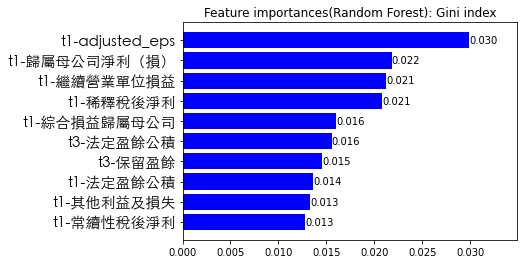

In [ ]:
plot_importance(rfModel3)

Accuracy:  0.9227642276422764


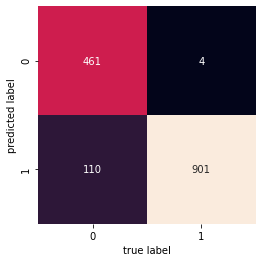

In [ ]:
# 訓練資料集上的結果
ytrain_pred3 = rfModel3.predict(xtrain3)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytrain_pred3, ytrain3)]))
mat = confusion_matrix(ytrain3, ytrain_pred3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

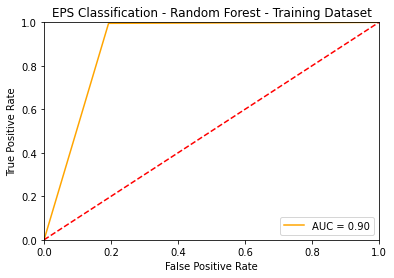

In [ ]:
# 訓練資料集的AUC
fpr, tpr, threshold = roc_curve(ytrain3, ytrain_pred3)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.5345528455284553


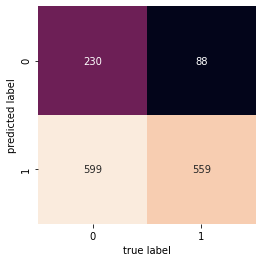

In [ ]:
# 驗證資料集上的結果
yvalid_pred3 = rfModel3.predict(xvalid3)
print('Accuracy: ', np.mean([i==j for i,j in zip(yvalid_pred3, yvalid3)]))
mat = confusion_matrix(yvalid3, yvalid_pred3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

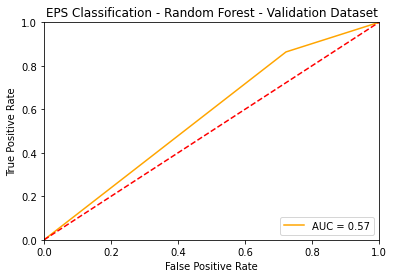

In [ ]:
# 驗證資料集的AUC
fpr, tpr, threshold = roc_curve(yvalid3, yvalid_pred3)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Validation Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.5724932249322493


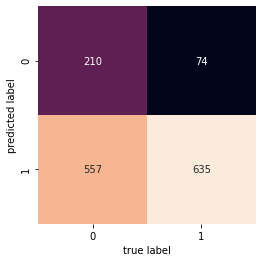

In [ ]:
# 測試資料集上的結果
ytest_pred3 = rfModel3.predict(xtest3)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytest_pred3, ytest3)]))
mat = confusion_matrix(ytest3, ytest_pred3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

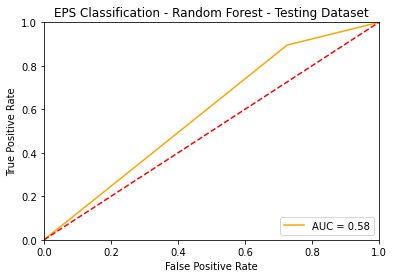

In [ ]:
# 測試資料集的AUC
fpr, tpr, threshold = roc_curve(ytest3, ytest_pred3)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Testing Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對隨機森林模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
# 訓練資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel3.predict_proba(xtrain3)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel3.predict_proba(xtrain3)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel3.predict_proba(xtrain3)]

In [ ]:
print("Training Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytrain3)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytrain3) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytrain3) if type(i)==int]))

Training Dataset
50-50 Accuracy:  0.9227642276422764
60-40 Accuracy:  0.9833479404031551
80-20 Accuracy:  1.0


In [ ]:
# 驗證資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel3.predict_proba(xvalid3)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel3.predict_proba(xvalid3)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel3.predict_proba(xvalid3)]

In [ ]:
print("Validation Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, yvalid3)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, yvalid3) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, yvalid3) if type(i)==int]))

Validation Dataset
50-50 Accuracy:  0.5345528455284553
60-40 Accuracy:  0.5786516853932584
80-20 Accuracy:  0.6111111111111112


In [ ]:
# 測試資料集上的結果
ypred50 = [int(i[1]>0.5) for i in rfModel3.predict_proba(xtest3)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel3.predict_proba(xtest3)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel3.predict_proba(xtest3)]

In [ ]:
print("Testing Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest3)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest3) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest3) if type(i)==int]))

Testing Dataset
50-50 Accuracy:  0.5724932249322493
60-40 Accuracy:  0.6261160714285714
80-20 Accuracy:  0.782051282051282


In [ ]:
pd.DataFrame(rfModel3.predict_proba(xtest3), index=xtest3.index, columns=['EPS下跌','EPS增加']).to_excel("./RF_validation.xlsx")

#### Xgboost模型

In [ ]:
xgbModel_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.8, 1.],
    'min_child_weight': [1, 5, 11],
    'eval_metric': ['logloss'], 
    'use_label_encoder':[False]
}

In [ ]:
start = time.time()
xgbModel3=GridSearchCV(XGBClassifier(), param_grid=xgbModel_param_grid, cv=pds, scoring='roc_auc', refit=False)
xgbModel3.fit(xtrain_valid3, ytrain_valid3)
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best AUC score: {:.4f}".format(xgbModel3.best_score_))
print("Best parameters: {}".format(xgbModel3.best_params_))

Time spent: 3845.8019 seconds
Best AUC score: 0.6746
Best parameters: {'colsample_bytree': 0.5, 'eval_metric': 'logloss', 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'use_label_encoder': False}


In [ ]:
best_parameters = xgbModel3.best_params_
xgbModel3 = XGBClassifier(n_estimators=best_parameters['n_estimators'], learning_rate=best_parameters['learning_rate'],
                          max_depth=best_parameters['max_depth'], gamma=best_parameters['gamma'], 
                          colsample_bytree=best_parameters['colsample_bytree'], min_child_weight=best_parameters['min_child_weight'],
                          random_state=0, eval_metric='logloss', use_label_encoder=False)
xgbModel3.fit(xtrain3, ytrain3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

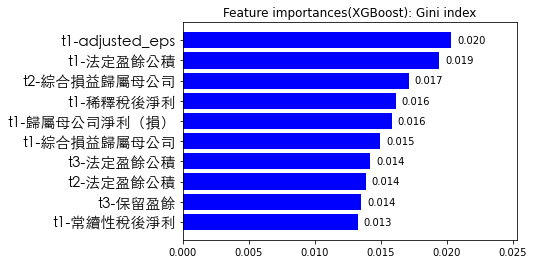

In [ ]:
plot_importance_xgb(xtrain3, xgbModel3)

Accuracy:  0.766260162601626


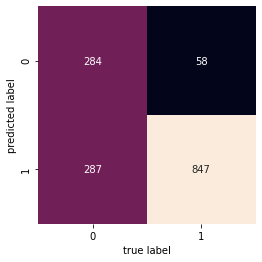

In [ ]:
# 訓練資料集上的結果
ytrain_pred3 = xgbModel3.predict(xtrain3)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytrain_pred3, ytrain3)]))
mat = confusion_matrix(ytrain3, ytrain_pred3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

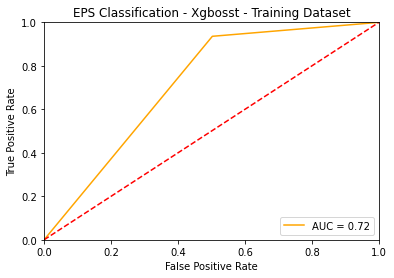

In [ ]:
# 訓練資料集的AUC
fpr, tpr, threshold = roc_curve(ytrain3, ytrain_pred3)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgbosst - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.559620596205962


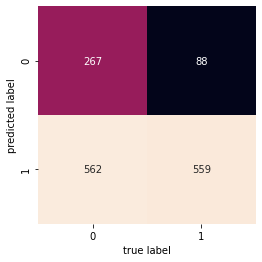

In [ ]:
# 驗證資料集上的結果
yvalid_pred3 = xgbModel3.predict(xvalid3)
print('Accuracy: ', np.mean([i==j for i,j in zip(yvalid_pred3, yvalid3)]))
mat = confusion_matrix(yvalid3, yvalid_pred3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

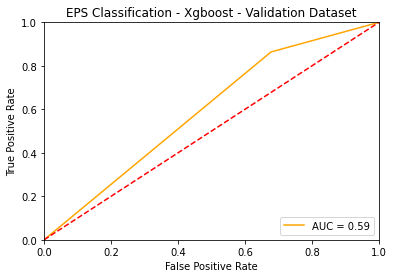

In [ ]:
# 驗證資料集的AUC
fpr, tpr, threshold = roc_curve(yvalid3, yvalid_pred3)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgboost - Validation Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.5860433604336044


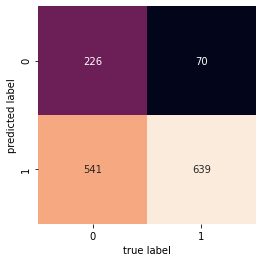

In [ ]:
# 測試資料集上的結果
ytest_pred3 = xgbModel3.predict(xtest3)
print('Accuracy: ', np.mean([i==j for i,j in zip(ytest_pred3, ytest3)]))
mat = confusion_matrix(ytest3, ytest_pred3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

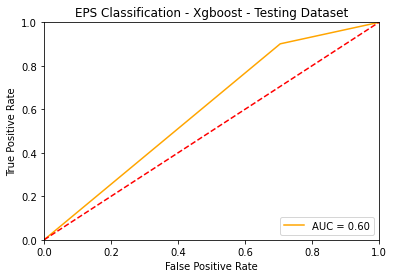

In [ ]:
# 測試資料集的AUC
fpr, tpr, threshold = roc_curve(ytest3, ytest_pred3)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Xgboost - Testing Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對Xgboost模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
# 訓練資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel3.predict_proba(xtrain3)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel3.predict_proba(xtrain3)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel3.predict_proba(xtrain3)]

In [ ]:
print("Training Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytrain3)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytrain3) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytrain3) if type(i)==int]))

Training Dataset
50-50 Accuracy:  0.766260162601626
60-40 Accuracy:  0.8591248665955176
80-20 Accuracy:  1.0


In [ ]:
# 驗證資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel3.predict_proba(xvalid3)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel3.predict_proba(xvalid3)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel3.predict_proba(xvalid3)]

In [ ]:
print("Validation Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, yvalid3)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, yvalid3) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, yvalid3) if type(i)==int]))

Validation Dataset
50-50 Accuracy:  0.559620596205962
60-40 Accuracy:  0.5985748218527316
80-20 Accuracy:  0.7619047619047619


In [ ]:
# 測試資料集上的結果
ypred50 = [int(i[1]>0.5) for i in xgbModel3.predict_proba(xtest3)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel3.predict_proba(xtest3)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel3.predict_proba(xtest3)]

In [ ]:
print("Testing Dataset")
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest3)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest3) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest3) if type(i)==int]))

Testing Dataset
50-50 Accuracy:  0.5860433604336044
60-40 Accuracy:  0.6334440753045404
80-20 Accuracy:  0.9230769230769231


In [ ]:
pd.DataFrame(xgbModel3.predict_proba(xtest3), index=xtest3.index, columns=['EPS下跌','EPS增加']).to_excel("./xgb_validation.xlsx")

### 採用交叉驗證

### 嘗試四

嘗試四採用交叉驗證法，訓練階段使用2012-2014的3個資產負債表以及2013-2014的2個損益表及2個現金流量表資料做為訓練資料集，預測2015的每股盈餘增長。並以交叉驗證法將訓練資料集依照公司切割為5等分，每次以其中4等分用以訓練，1等分用以驗證，用以找到最佳參數。測試階段使用表現最好的參數模型，利用2013-2015的3個資產負債表以及2014-2015的2個損益表及2個現金流量表資料去預測2016的每股盈餘增長。

In [ ]:
xtrain4 = pd.DataFrame(index=input_data.index)
year = 2016
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtrain4["t4-"+acc] = input_data[str(year-4)+"_"+acc] # added
        xtrain4["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtrain4["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtrain4["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtrain4["t3-"+acc] = input_data[str(year-3)+"_"+acc] # added
        xtrain4["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtrain4["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytrain4 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented fr

In [ ]:
xtest4 = pd.DataFrame(index=input_data.index)
year = 2017
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        xtest4["t4-"+acc] = input_data[str(year-4)+"_"+acc] # added
        xtest4["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtest4["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest4["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        xtest4["t3-"+acc] = input_data[str(year-3)+"_"+acc] # added
        xtest4["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest4["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytest4 = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented fr

In [ ]:
# 隨機將公司拆成5等分
random.seed(20220406)
companies = list(input_data.index)
companies_len = len(companies)
group = []
for i in range(5):
    if i == 4:
        group.append(companies)
    else:
        group_i = random.sample(companies, k=math.floor(companies_len/5))
        group.append(group_i)
        companies = list(set(companies).difference(set(group_i)))

#### 隨機森林模型（Random Forest）

要做好參數的調整，使用網格搜索（Grid Search）的方式來進行參數的自動調整。

In [ ]:
# 設定要調整的參數以及其選項
rfModel_param_grid = {
    'bootstrap': [True],
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [10, 20, 30 ,40, 'log2', 'sqrt']
}

In [ ]:
start = time.time()
best_score = 0
for estimator in rfModel_param_grid['n_estimators']:
    for min_samples_leaf in rfModel_param_grid['min_samples_leaf']:
        for max_sample in rfModel_param_grid['max_samples']:
            for max_feature in rfModel_param_grid['max_features']:
                rfModel4 = RandomForestClassifier(n_estimators=estimator, max_samples=max_sample, min_samples_leaf=min_samples_leaf,
                                                  max_features=max_feature, bootstrap=True, random_state=0)
                # 使用交叉驗證法，fold=5，取其score平均值
                score_list = []
                for g in group:
                    x_train = xtrain4.loc[set(input_data.index)-set(g),]
                    y_train = ytrain4.loc[set(input_data.index)-set(g),]
                    x_valid = xtrain4.loc[g,]
                    y_valid = ytrain4.loc[g,]
                    rfModel4.fit(x_train, y_train)
                    score_list.append(rfModel4.score(x_valid, y_valid))
                mean_score = sum(score_list)/len(score_list)
                if mean_score > best_score:
                    best_score = mean_score
                    best_parameters = {'bootstrap': [True], 
                                       'n_estimators': estimator,
                                       'min_samples_leaf': min_samples_leaf,
                                       'max_samples': max_sample,
                                       'max_features': max_feature}
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Time spent: 735.3689 seconds
Best score: 0.64
Best parameters: {'bootstrap': [True], 'n_estimators': 20, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': 30}


In [ ]:
rfModel4 = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], max_samples=best_parameters['max_samples'], 
                                  min_samples_leaf=best_parameters['min_samples_leaf'], max_features=best_parameters['max_features'],
                                  bootstrap=True, random_state=0)
rfModel4.fit(xtrain4, ytrain4)

RandomForestClassifier(max_features=30, max_samples=0.8, min_samples_leaf=2,
                       n_estimators=20, random_state=0)

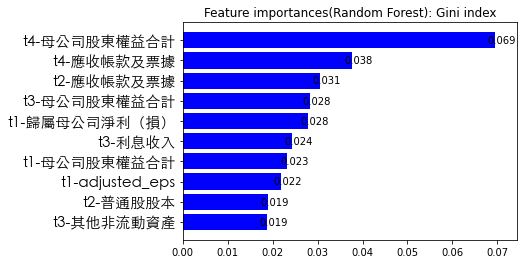

In [ ]:
plot_importance(rfModel4)

Accuracy:  0.9468599033816425


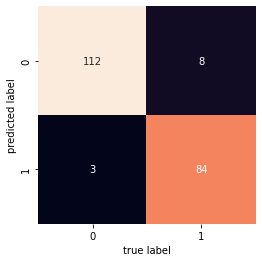

In [ ]:
# 訓練資料集上的結果
ypred4 = rfModel4.predict(xtrain4)
print('Accuracy: ', np.mean([i==j for i,j in zip(ypred4, ytrain4)]))
mat = confusion_matrix(ytrain4, ypred4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

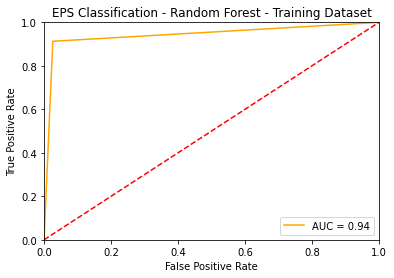

In [ ]:
# 訓練資料集上的AUC
fpr, tpr, threshold = roc_curve(ytrain4, ypred4)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.5072463768115942


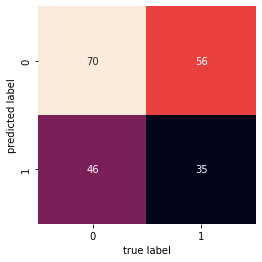

In [ ]:
# 測試資料集上的結果
ypred4 = rfModel4.predict(xtest4)
print('Accuracy: ', np.mean([i==j for i,j in zip(ypred4, ytest4)]))
mat = confusion_matrix(ytest4, ypred4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

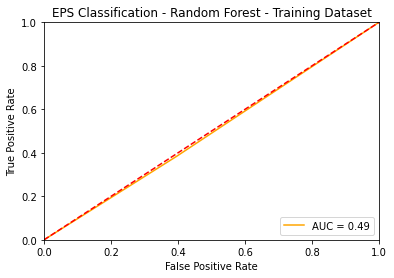

In [ ]:
# 訓練資料集上的AUC
fpr, tpr, threshold = roc_curve(ytest4, ypred4)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

最後，針對隨機森林模型採用三種不一樣的衡量條件：
1. 模型預測機率大於50%認定為1，反之則為0
2. 模型預測機率大於60%認定為1，小於40%認定為0
3. 模型預測機率大於80%認定為1，小於20%認定為0


分別計算其正確率。

In [ ]:
ypred50 = [int(i[1]>0.5) for i in rfModel4.predict_proba(xtest4)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in rfModel4.predict_proba(xtest4)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in rfModel4.predict_proba(xtest4)]

In [ ]:
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest4)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest4) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest4) if type(i)==int]))

50-50 Accuracy:  0.5072463768115942
60-40 Accuracy:  0.5474452554744526
80-20 Accuracy:  0.59375


In [ ]:
# 將預測結果存成excel檔
RF_test4 = pd.DataFrame(columns=['年分','EPS下跌機率','EPS增加機率','eps_indicator','eps_delta','adjusted_eps','調整因子'], index=xtest4.index)
RF_test4[['EPS下跌機率','EPS增加機率']] = rfModel4.predict_proba(xtest4)
RF_test4['年分'] = year
RF_test4['eps_indicator'] = ytest4
RF_test4['eps_delta'] = eps_delta[f'{year}_delta_eps']
RF_test4['adjusted_eps'] = input_data[f'{year}_adjusted_eps']
RF_test4['調整因子'] = list(eps_df.set_index(['公司', 'year']).loc(axis=0)[RF_test4.index, str(year)]['調整因子'])
RF_test4.to_excel("./RF_test4.xlsx")

#### Xgboost模型

In [ ]:
xgbModel_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.8, 1.],
    'min_child_weight': [1, 5, 11]
}

In [ ]:
start = time.time()
best_score = 0
for estimator in xgbModel_param_grid['n_estimators']:
    for max_depth in xgbModel_param_grid['max_depth']:
        for lr in xgbModel_param_grid['learning_rate']:
            for gamma in xgbModel_param_grid['gamma']:
                for colsample_bytree in xgbModel_param_grid['colsample_bytree']:
                    for min_child in xgbModel_param_grid['min_child_weight']:
                        xgbModel4 = XGBClassifier(n_estimators=estimator, learning_rate=lr, max_depth=max_depth,
                                                  gamma=gamma, colsample_bytree=colsample_bytree, 
                                                  min_child_weight=min_child, random_state=0, 
                                                  eval_metric='logloss', use_label_encoder=False)
                        # 使用交叉驗證法，fold=5，取其score平均值
                        score_list = []
                        for g in group:
                            x_train = xtrain4.loc[set(input_data.index)-set(g),]
                            y_train = ytrain4.loc[set(input_data.index)-set(g),]
                            x_valid = xtrain4.loc[g,]
                            y_valid = ytrain4.loc[g,]
                            xgbModel4.fit(x_train, y_train)
                            score_list.append(xgbModel4.score(x_valid, y_valid))
                        mean_score = sum(score_list)/len(score_list)
                        if mean_score > best_score:
                            best_score = mean_score
                            best_parameters = {'n_estimators': estimator,
                                               'max_depth': max_depth,
                                               'learning_rate': lr,
                                               'gamma': gamma,
                                               'colsample_bytree': colsample_bytree,
                                               'min_child_weight': min_child}
end = time.time()
print('Time spent: %.4f seconds' % (end-start))
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Time spent: 2354.1925 seconds
Best score: 0.62
Best parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.005, 'gamma': 0, 'colsample_bytree': 0.5, 'min_child_weight': 1}


In [ ]:
xgbModel4 = XGBClassifier(n_estimators=best_parameters['n_estimators'], learning_rate=best_parameters['learning_rate'],
                          max_depth=best_parameters['max_depth'], gamma=best_parameters['gamma'], 
                          colsample_bytree=best_parameters['colsample_bytree'], min_child_weight=best_parameters['min_child_weight'],
                          random_state=0, eval_metric='logloss', use_label_encoder=False)
xgbModel4.fit(xtrain4, ytrain4)

XGBClassifier(colsample_bytree=0.5, eval_metric='logloss', learning_rate=0.005,
              max_depth=4, use_label_encoder=False)

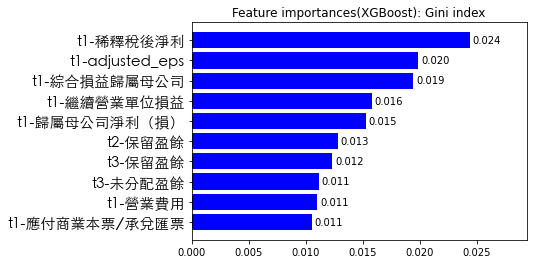

In [ ]:
plot_importance_xgb(xtrain4, xgbModel4)

Accuracy:  0.9710144927536232


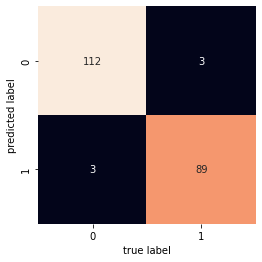

In [ ]:
# 訓練資料集上的結果
ypred4 = xgbModel4.predict(xtrain4)
print('Accuracy: ', np.mean([i==j for i,j in zip(ypred4, ytrain4)]))
mat = confusion_matrix(ytrain4, ypred4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

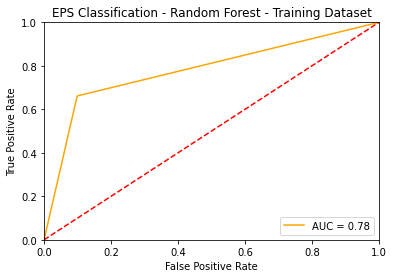

In [ ]:
# 訓練資料集上的AUC
fpr, tpr, threshold = roc_curve(ytrain4, ypred4)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Accuracy:  0.5217391304347826


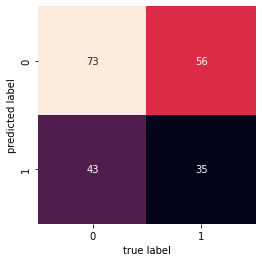

In [ ]:
# 測試資料集上的結果
ypred4 = xgbModel4.predict(xtest4)
print('Accuracy: ', np.mean([i==j for i,j in zip(ypred4, ytest4)]))
mat = confusion_matrix(ytest4, ypred4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

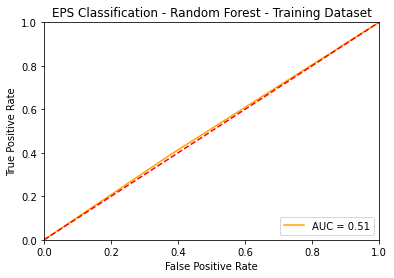

In [ ]:
# 測試資料集上的AUC
fpr, tpr, threshold = roc_curve(ytest4, ypred4)
auc1 = auc(fpr, tpr)
plt.title('EPS Classification - Random Forest - Training Dataset')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [ ]:
ypred50 = [int(i[1]>0.5) for i in xgbModel4.predict_proba(xtest4)]
ypred60 = [i[1] if (i[1]<=0.6 and i[1]>=0.4) else int(i[1]>0.6) for i in xgbModel4.predict_proba(xtest4)]
ypred80 = [i[1] if (i[1]<=0.8 and i[1]>=0.2) else int(i[1]>0.8) for i in xgbModel4.predict_proba(xtest4)]

In [ ]:
print("50-50 Accuracy: ", np.mean([i==j for i, j in zip(ypred50, ytest4)]))
print("60-40 Accuracy: ", np.mean([i==j for i, j in zip(ypred60, ytest4) if type(i)==int]))
print("80-20 Accuracy: ", np.mean([i==j for i, j in zip(ypred80, ytest4) if type(i)==int]))

50-50 Accuracy:  0.5217391304347826
60-40 Accuracy:  0.5555555555555556
80-20 Accuracy:  nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# 將預測結果存成excel檔
xgb_test4 = pd.DataFrame(columns=['年分','EPS下跌機率','EPS增加機率','eps_indicator','eps_delta','adjusted_eps','調整因子'], index=xtest4.index)
xgb_test4[['EPS下跌機率','EPS增加機率']] = xgbModel4.predict_proba(xtest4)
xgb_test4['年分'] = year
xgb_test4['eps_indicator'] = ytest4
xgb_test4['eps_delta'] = eps_delta[f'{year}_delta_eps']
xgb_test4['adjusted_eps'] = input_data[f'{year}_adjusted_eps']
xgb_test4['調整因子'] = list(eps_df.set_index(['公司', 'year']).loc(axis=0)[xgb_test4.index, str(year)]['調整因子'])
xgb_test4.to_excel("./xgb_test4.xlsx")

# 其他課的東西




In [7]:
import math
import pandas as pd
import numpy as np
import random

In [ ]:
# 輸出結果
np.savetxt("result 5.csv", return_2.astype(int), delimiter=",")